## Predictions on pet adoption speed - Gradient Boosting Ensembles with imbalanced class learning (a hybrid approach combining SMOTE re-sampling & one-class outlier detection)

This post worked on the Kaggle competition dataset provided by the PetFinder.my, aiming to predict on the adoption speed of a certain pet by the adoptors.
https://www.kaggle.com/c/petfinder-adoption-prediction/data

It consists of around 15,000 records of adoptions containing features about the pet's profile and health status, with complements of around 58,300 images of the pets and json files provided from sentiment detections by Google Natural Language Processing's API. Image metadata files were given by Google's Vision API on generating image properties, key feature tagging and face annotations, etc. These three sets of features were then processed to analysis and model testing.

The following chunks of codes were demonstrated for data loading from json files, feature extractions and engineering process and classifier formulation for the target. The general flow can be concluded in brief:
<ul><p style="font-size:200%">i) Extraction & Load:</p>
<ul><li>base set of features from a csv file</li>
      <li>text features from pet descriptions & image metadata descriptions</li>
      <li>image features from pet images</li></ul></ul>
<ul><p style="font-size:200%">ii) Feature Engineering:</p>
<ul><li>Target feature: one-hot encoded in a way considering proportional odds to retain ordinal scale</li>
      <li>Text features: created representations by TFIDF-weighted word count vectors & Doc2Vec embedding vectors</li>
      <li>Image features: created representations from Convolutional Autoencoder; 
        followed by dimensionality reduction by Non-Negative Matrix Factorization;
        further grouping similar images per each pet ID by soft clustering approach of DBSCAN</li></ul></ul>
<ul><p style="font-size:200%">iii) Training Gradient Boosting Tree Classifier:</p>
<ul><li>original feature set for benchmarking</li>
      <li>re-sampled feature set + added outlier features combined with original feature set</li></ul></ul>


In [0]:
from nltk import word_tokenize
from nltk import corpus
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import imageio
import torch
import os

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [0]:
## Download dataset from Kaggle
!kaggle competitions download --force -c petfinder-adoption-prediction

In [0]:
!unzip train.zip
!unzip train_metadata.zip -d train_metadata
!unzip train_sentiment.zip -d train_sentiment
!unzip train_images.zip -d train_images
!unzip test.zip
!unzip test_metadata.zip -d test_metadata
!unzip test_sentiment.zip -d test_sentiment
!unzip test_images.zip -d test_images

In [0]:
## define stopword list
stop_words = corpus.stopwords.words('english')
## cleaning noises in texts
def normalize_doc(doc):
    # lower-case
    doc = doc.lower()
    # substitute special characters, digits & punctuations
    doc = re.sub('<br/>', ' ', doc)
    doc = re.sub("'s|'m|'re|'ve|'ll|'d|n't", ' ', doc)
    doc = re.sub(r'[^a-zA-Z\s]\W+|\d+|[(){}<>!@#$&/\.:;_=]+', ' ', doc)
    # remove leading and trailing spaces
    doc = doc.strip()
    # tokenize
    tokens = word_tokenize(doc)
    # discard stopwords
    filtered_tokens = [x for x in tokens if x not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

In [0]:
df = pd.read_csv('train.csv')
## Pet Descriptions
des = df['Description']
## tokenization
des_list = []
des_list = [normalize_doc(str(x)) for x in des]

In [0]:
## Do lemmatization before creating TF-IDF
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
## define Part-of-Speech
def get_pos(word):
    w_synsets = wordnet.synsets(word)
    pos = Counter()
    pos["n"] = len([item for item in w_synsets if item.pos()=="n"])
    pos["v"] = len([item for item in w_synsets if item.pos()=="v"])
    pos["a"] = len([item for item in w_synsets if item.pos()=="a"])
    pos["r"] = len([item for item in w_synsets if item.pos()=="r"])
    most_common_pos_list = pos.most_common(3)
    # first indexer for getting the top POS from list,
    # second indexer for getting POS from tuple
    return most_common_pos_list[0][0]

des_lem_list = []
for n in range(len(des_list)):
    lem_list = []
    for w in des_list[n].split():
        lem_list.append(wnl.lemmatize(w, get_pos(w)))
    des_lem_list.append(lem_list)

from sklearn.feature_extraction.text import TfidfVectorizer

des_lemm_list = []
for n in range(len(des_lem_list)):
    des_lemm_list.append(' '.join(des_lem_list[n]))

## create TF-IDF matrix
tfidf = TfidfVectorizer(min_df=3, max_df=0.9, use_idf=True)
tfidf_matrix = tfidf.fit_transform(des_lemm_list)
tfidf_terms = tfidf.get_feature_names()
tfidf_matrix = tfidf_matrix.toarray()
tfidf_doc_matrix = pd.DataFrame(tfidf_matrix, columns=tfidf_terms)

In [0]:
## feature mapping process:
### i) mixed breed / single breed type
breed = []
for i in range(len(df)):
    if df['Breed1'][i] == 0 or df['Breed2'][i] == 0:
        breed.append(0)
    elif df['Breed1'][i] == df['Breed2'][i]:
        breed.append(1)
    else:
        breed.append(2)
df['breed_type'] = pd.Series(breed)

### ii) breed identity
breed_matrix = np.zeros((len(df), max(max(df['Breed1']), max(df['Breed2']))))
for i in range(len(df)):
    if df['Breed1'][i] > 0:
        b1 = df['Breed1'][i]
        breed_matrix[i, b1-1] += 1
    if df['Breed2'][i] > 0 and df['Breed2'][i] != df['Breed1'][i]:
        b2 = df['Breed2'][i]
        breed_matrix[i, b2-1] += 1     
breed_label = pd.DataFrame(breed_matrix)

breed_col = []
for v in range(breed_matrix.shape[1]):
    breed_col.append('breed_' + str(v+1))
breed_label.columns = breed_col

### iii) number of colors
count_color = []
for i in range(len(df)):
    if df['Color1'][i] > 0:
        count_colors = 1
    if df['Color2'][i] > 0:
        count_colors += 1
    if df['Color3'][i] > 0:
        count_colors += 1
    count_color.append(count_colors)
count_color = pd.DataFrame(count_color)
count_color.columns = ['count_color']

### iv) color identity
color_matrix = np.zeros((len(df), max(max(df['Color1']), max(df['Color2']), max(df['Color3']))))
for i in range(len(df)):
    if df['Color1'][i] > 0:
        c1 = df['Color1'][i]
        color_matrix[i, c1-1] += 1
    if df['Color2'][i] > 0:
        c2 = df['Color2'][i]
        color_matrix[i, c2-1] += 1
    if df['Color3'][i] > 0:
        c3 = df['Color3'][i]
        color_matrix[i, c3-1] += 1
color_label = pd.DataFrame(color_matrix)

color_col = []
for u in range(color_matrix.shape[1]):
    color_col.append('color_' + str(u+1))
color_label.columns = color_col

### v) state of Malaysia
state = pd.get_dummies(df['State'])   
state_index = state.columns
state_col = []
for s in state_index:
    state_col.append('state_' + str(s))
state.columns = state_col

### vi) length of descriptions
len_desc = []
for i in range(len(df)):
    c = len(str(df['Description'][i]))
    len_desc.append(c)
len_desc = pd.DataFrame(len_desc)
len_desc.columns = ['Length_Descriptions']

In [0]:
## sentiment data import
import json
import os, os.path

direct = './train_sentiment/'
sentiment = []
for js in range(len([name for name in os.listdir(direct) 
            if os.path.isfile(os.path.join(direct, name))])):
    with open(os.path.join(direct, os.listdir(direct)[js]), encoding="utf8") as json_file:
        jsondata = json.load(json_file)
        json_petid = pd.DataFrame({'PetID': str(os.listdir(direct)[js]).split('.')[0]}, index=[0])
        json_magnitude = pd.DataFrame({'doc_magnitude': 
                                       jsondata['documentSentiment']['magnitude']}, index=[0])
        json_sentiment_score = pd.DataFrame({'doc_score': 
                                             jsondata['documentSentiment']['score']}, index=[0])
        json_sentences_sentiment = [x['sentiment'] for x in jsondata['sentences']]
        json_sentences_sentiment = pd.DataFrame.from_dict(json_sentences_sentiment, orient='columns')
        json_sentences_sentiment_df = pd.DataFrame(
            {
                'sent_magnitude_sum': json_sentences_sentiment['magnitude'].sum(axis=0),
                'sent_score_sum': json_sentences_sentiment['score'].sum(axis=0),
                'sent_magnitude_mean': json_sentences_sentiment['magnitude'].mean(axis=0),
                'sent_score_mean': json_sentences_sentiment['score'].mean(axis=0),
                'sent_magnitude_var': json_sentences_sentiment['magnitude'].var(axis=0),
                'sent_score_var': json_sentences_sentiment['score'].var(axis=0),
            }, index=[0]
        )
        sentiment.append(pd.concat([json_petid,json_magnitude,
                                    json_sentiment_score,json_sentences_sentiment_df], axis=1))

sent = pd.concat(sentiment)
sent = sent.reset_index(drop=True)

In [0]:
## image properties data - using only the 1st profile picture for each pet ID
!pip install flatten_json
from flatten_json import flatten

dir_img = './train_metadata/'
img_prop_list = []
face_list = []
for js in range(len([name for name in os.listdir(dir_img)])):
    if '-1.json' in os.listdir(dir_img)[js]:
        with open(os.path.join(dir_img, os.listdir(dir_img)[js]), encoding="utf8") as json_img:
            jsondata_img = json.load(json_img)
            
            json_petid = pd.DataFrame({'PetID': str(os.listdir(dir_img)[js]).split('-')[0]}, index=[0])
            
            if 'labelAnnotations' in jsondata_img:
                jsonmeta_annot = jsondata_img['labelAnnotations']
                labelannot_topic_score = np.asarray([x['score'] for x in jsonmeta_annot]).mean()
                labelannot_topic_desc = [x['description'] for x in jsonmeta_annot]
            else:
                labelannot_topic_score = np.nan
                labelannot_topic_desc = ['']
            
            jsonmeta_color = jsondata_img['imagePropertiesAnnotation']['dominantColors']['colors']
            color_score = np.asarray([x['score'] for x in jsonmeta_color]).mean()
            color_pixelfrac = np.asarray([x['pixelFraction'] for x in jsonmeta_color]).mean()
            
            jsonmeta_cropHint = jsondata_img['cropHintsAnnotation']['cropHints']
            crop_confidence = np.asarray([x['confidence'] for x in jsonmeta_cropHint]).mean()
            if 'importanceFraction' in jsonmeta_cropHint[0].keys():
                crop_importance = np.asarray([x['importanceFraction'] for x in jsonmeta_cropHint]).mean()
            else:
                crop_importance = np.nan
            
            df_metadata = {
                'labelannot_topic_score': labelannot_topic_score,
                'color_score': color_score,
                'color_pixelfrac': color_pixelfrac,
                'crop_confidence': crop_confidence,
                'crop_importance': crop_importance,
                'labelannot_topic_desc': ' '.join(labelannot_topic_desc)
                }
        
            df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
            df_metadata = df_metadata.add_prefix('metadata_')
        
            img_prop_list.append(pd.concat([json_petid, df_metadata], axis=1))
            
            ## read if there are face annotations and emotion-likelihood features
            if 'faceAnnotations' in jsondata_img:
                json_face_annot_roll_angle = [x['rollAngle'] for x in jsondata_img['faceAnnotations']]
                json_face_annot_pan_angle = [x['panAngle'] for x in jsondata_img['faceAnnotations']]
                json_face_annot_tilt_angle = [x['tiltAngle'] for x in jsondata_img['faceAnnotations']]
                
                json_face_annot_confidence = [x['detectionConfidence'] 
                                              for x in jsondata_img['faceAnnotations']]
                json_face_annot_lm_confidence = [x['landmarkingConfidence'] 
                                                 for x in jsondata_img['faceAnnotations']]
                
                json_face_annot_joy = [x['joyLikelihood'] 
                                       for x in jsondata_img['faceAnnotations']]
                json_face_annot_sorrow = [x['sorrowLikelihood'] 
                                          for x in jsondata_img['faceAnnotations']]
                json_face_annot_anger = [x['angerLikelihood'] 
                                         for x in jsondata_img['faceAnnotations']]
                json_face_annot_surprise = [x['surpriseLikelihood'] 
                                            for x in jsondata_img['faceAnnotations']]
                json_face_annot_exposed = [x['underExposedLikelihood'] 
                                           for x in jsondata_img['faceAnnotations']]
                json_face_annot_blurred = [x['blurredLikelihood'] 
                                           for x in jsondata_img['faceAnnotations']]
                json_face_annot_headwear = [x['headwearLikelihood'] 
                                            for x in jsondata_img['faceAnnotations']]
                
            else:
                json_face_annot_roll_angle = np.nan
                json_face_annot_pan_angle = np.nan
                json_face_annot_tilt_angle = np.nan
                json_face_annot_confidence = np.nan
                json_face_annot_lm_confidence = np.nan
                json_face_annot_joy = ['']
                json_face_annot_sorrow = ['']
                json_face_annot_anger = ['']
                json_face_annot_surprise = ['']
                json_face_annot_exposed = ['']
                json_face_annot_blurred = ['']
                json_face_annot_headwear = ['']
                
            df_facedata = {
                    'rollAngle': json_face_annot_roll_angle,
                    'panAngle': json_face_annot_pan_angle,
                    'tiltAngle': json_face_annot_tilt_angle,
                    
                    'detect_confidence': json_face_annot_confidence,
                    'landmark_confidence': json_face_annot_lm_confidence,
                    
                    'joyLikelihood': json_face_annot_joy,
                    'sorrowLikelihood': json_face_annot_sorrow,
                    'angerLikelihood': json_face_annot_anger,
                    'surpriseLikelihood': json_face_annot_surprise,
                    'exposedLikelihood': json_face_annot_exposed,
                    'blurredLikelihood': json_face_annot_blurred,
                    'headwearLikelihood': json_face_annot_headwear
                    }
            
            df_facedata = pd.DataFrame.from_dict(df_facedata, orient='index').T
            df_facedata = df_facedata.add_prefix('facedata_')
            
            face_list.append(pd.concat([json_petid, df_facedata], axis=1))

img_prop = pd.concat(img_prop_list)
img_prop = img_prop.reset_index(drop=True)
img_prop['Length_metadata_labelannot_topic_desc'] = img_prop['metadata_labelannot_topic_desc'].apply(
                                                                                      lambda x: len(x))

face_annot = pd.concat(face_list)
face_annot = face_annot.reset_index(drop=True)

#### **Text Feature Extraction**

Following steps for processing language based features from text data:
<ul>
<li>Normalization and Lemmatization
  <ul><li>cleaning stopwords and redundant characters through regex strings</li>
      <li>WordNet Lemmatizer from NLTK library</li></ul></li>
<li>TF-IDF weighted matrix built on tokens obtained above
  <ul><li>counting word occurrences in the corpus</li>
      <li>multiplied by a factor of inverse document fequency to penalize frequent words across documents</li>
      <li>truncated SVD might be applied to reduce dimensionality; here feature size was limited by minimum and maximum appearances</li></ul></li>
<li>Doc2Vec embedding from pre-trained applications
  <ul><li>generating vectors of 100 dimensions from the Doc2Vec model pipelined in Gensim library</li>
      <li>learning on word positions and sequences converting into state vectors</li></ul></li>


In [0]:
## create vectors for the image label annotation descriptions
metadata_label_annot_desc_tfidf = TfidfVectorizer(min_df=1, max_df=0.99, use_idf=True)
metadata_label_annot_desc_tfidf_matrix = metadata_label_annot_desc_tfidf.fit_transform(
                                            img_prop['metadata_labelannot_topic_desc'])
metadata_label_annot_desc_tfidf_terms = metadata_label_annot_desc_tfidf.get_feature_names()
metadata_label_annot_desc_tfidf_matrix = metadata_label_annot_desc_tfidf_matrix.toarray()
metadata_label_annot_desc_tfidf_matrix = pd.DataFrame(metadata_label_annot_desc_tfidf_matrix, 
                                                      columns=metadata_label_annot_desc_tfidf_terms)

img_metadata = pd.concat([img_prop.iloc[:,np.r_[0:6,7]], metadata_label_annot_desc_tfidf_matrix], axis=1)

In [0]:
from gensim.models import word2vec, doc2vec

## Train a Doc2Vec model for the review and summary texts
documents = [doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(des_list)]
d2v = doc2vec.Doc2Vec(documents, vector_size=500, window=20, min_count=2, seed=1, workers=1)
d2v.train(documents, total_examples=len(documents), epochs=50)

## Train a Doc2Vec model to metadata image annotation descriptions
meta_annot_doc = [doc2vec.TaggedDocument(meta, [i]) 
                for i, meta in enumerate(img_prop['metadata_labelannot_topic_desc'])]
d2v_meta_annot = doc2vec.Doc2Vec(meta_annot_doc, vector_size=100, 
                                 window=20, min_count=2, seed=1, workers=1)
d2v_meta_annot.train(meta_annot_doc, total_examples=len(documents), epochs=50)

In [0]:
## extract vectorized pet descriptions
doc_v = []
doc_label = []
for doc in range(len(d2v.docvecs)):
    doc_v.append(d2v.docvecs[doc])
    doc_label.append('Pet' + str(doc+1))
doc_v = np.array(doc_v)
doc_v = pd.DataFrame(doc_v)
doc_vec = []
for n in range(doc_v.shape[1]):
    doc_vec.append('description_d2v_vector' + str(n+1))
doc_v.columns = doc_vec

In [0]:
## extract vectorized pet descriptions
meta_doc_v = []
meta_doc_label = []
for metadoc in range(len(d2v_meta_annot.docvecs)):
    meta_doc_v.append(d2v.docvecs[metadoc])
    meta_doc_label.append('Pet' + str(metadoc+1))
meta_doc_v = np.array(meta_doc_v)
meta_doc_v = pd.DataFrame(meta_doc_v)
meta_doc_vec = []
for n in range(meta_doc_v.shape[1]):
    meta_doc_vec.append('meta_image_annotation_d2v_vector' + str(n+1))
meta_doc_v.columns = meta_doc_vec

img_metadata_doc_vector = pd.concat([img_prop.iloc[:,np.r_[0:6,7]], meta_doc_v], axis=1)

In [0]:
## filling the duplicated row per PetID
for r in range(len(face_annot)):
   if pd.isnull(face_annot['PetID'][r]):
       face_annot['PetID'][r] = face_annot['PetID'][r-1]

## checking duplicated PetID
face_dup = face_annot[face_annot.duplicated(['PetID'], keep=False)]
## extract rows with face annotation data
face_nonmiss = face_annot[face_annot.isnull().any(1)==False]
## label-encoding face emotion features
LabelEncode_map_face_emotion = {'VERY_UNLIKELY':0, 'UNLIKELY':1, 'POSSIBLE':2, 
                                'LIKELY':3, 'VERY_LIKELY':4}
face_label = face_nonmiss.iloc[:,6:face_nonmiss.shape[1]].replace(LabelEncode_map_face_emotion)
face_nonmiss.iloc[:,1:6] = face_nonmiss.iloc[:,1:6].astype('float')
face_nonmiss = pd.concat([face_nonmiss.iloc[:,0:6], face_label], axis=1)

In [0]:
## RescuerID Count
rescuer_count = df.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']
rescuer_pet = df[['PetID', 'RescuerID']].merge(rescuer_count, 
                left_on='RescuerID', right_on='RescuerID', how='left')

In [0]:
## Prepare dataframe
target = df[['Gender', 'breed_type', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 
             'Health', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 'PetID']]
## merge sentiment features to target dataframe
target = target.merge(sent, left_on = 'PetID', right_on = 'PetID', how = 'left')
## merge image metadata features to target dataframe
target = target.merge(img_prop, left_on = 'PetID', right_on = 'PetID', how = 'left')
## map the engineered features
target = pd.concat([target, count_color, len_desc, rescuer_pet['RescuerID_COUNT']], axis=1)

## convert to categorical from numerical labels
for n in target.columns[0:8]:
    target[n] = target[n].astype('category')
for n in target.columns[23:28]:
    target[n] = target[n].astype('float')

#### **Handling imbalanced classes**

From the visualization of the target variable, "Adoption Speed", being ordinally and unevenly grouped into 5 levels: "Same day", "Within 1 week", "Within 1 month", "Within 90 days" and "No adoption within 90 days", was highly imbalanced. The classification task hence would be suffering from problems of possibly poor recall and F1 score performance on predicting test samples (it might learn to be conservative in discriminating the rare positive class / predicting all test samples as negative class). 

Htpothetizing a few ideas on representing the target attribute, we could try either by encoding it into a multi-class labelled output, or into an one-vs-all setting of binary vectors for each class, or to encode the binary vectors in a way similar to odds to retain its ordinal characteristic. For this analysis, the last setting was applied.

Rare classes are common in real-world data, yet challenging to deal with as the performance of most classification algorithms designed are generally affected by the distribution of the target classes. Improvements may be made considering the following convenient approaches:

<ul><li>tuning the cost function or changing the model evaluation metrics to AUC-ROC score to balance the recall and specificity</li>
  <li>setting an optimized cut-off on predicted probabilities using learnable functions</li>
  <li>over-sampling the minority class or under-sampling the majority classes; typically synthesizing samples by ADASYN or SMOTE based algorithms</li></ul>

Python's "imblearn" library comprises of mainstream resampling algorithms: <br>
https://imbalanced-learn.readthedocs.io/en/stable/index.html

But still worth noting, over-sampling could amplify the weightings from small samples, while under-sampling discards a large number of majority class samples, which might lead to biased learning if the assumptions of traininig and testing data from similar distributions are violated. Some resampling algorithms selectively sample the data points clearly discriminated by the decision boundary (e.g. SVM-SMOTE and Borderline SMOTE for oversampling; Edited Nearest Neighbours for under-sampling); while some target on confounding and noisy data that are not easily classified with nearest-neighbors (e.g. ADASYN for oversampling; Condensed Nearest Neighbours for under-sampling). The effects of the re-sampling approaches might still be small in an extremely rare event prediction problem. 

Another strategy intuitively goes to treating rare class as anomalies in the population, then additional features measuring the likelihood of an observation being an outlier (e.g. with Mahalanobis distance, Local outlier factor, one-class SVM score, isolation forest probabilities, etc.) would provide more information from an unsupervised approach.

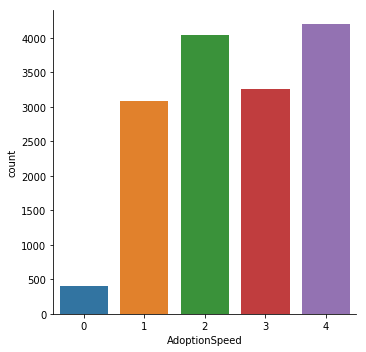

In [0]:
## Distribution of the prediction target: Adoption Speed
sb.catplot(x='AdoptionSpeed', data=target, kind='count')

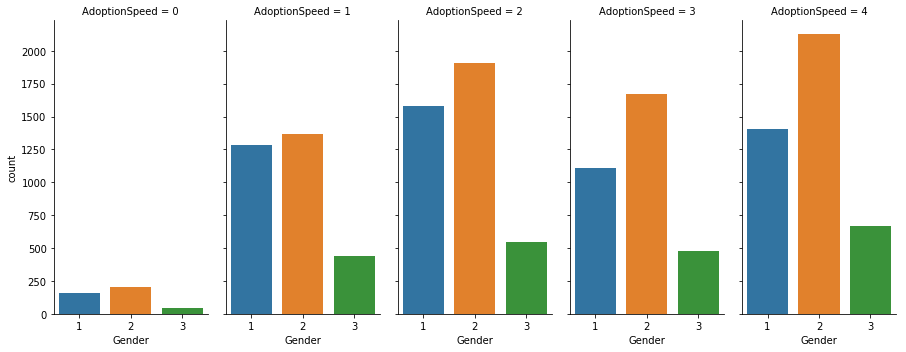

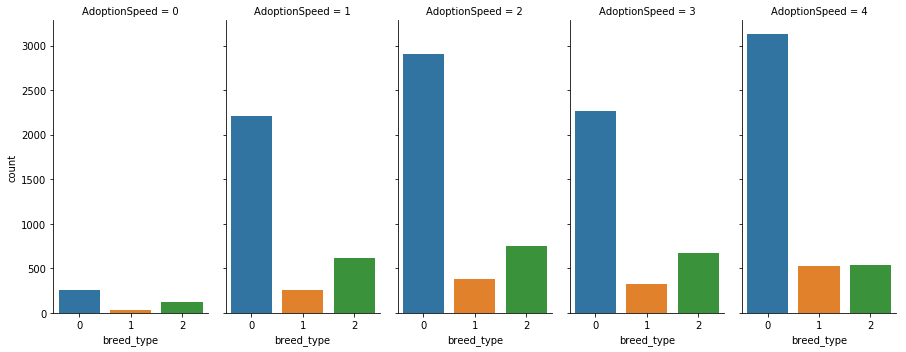

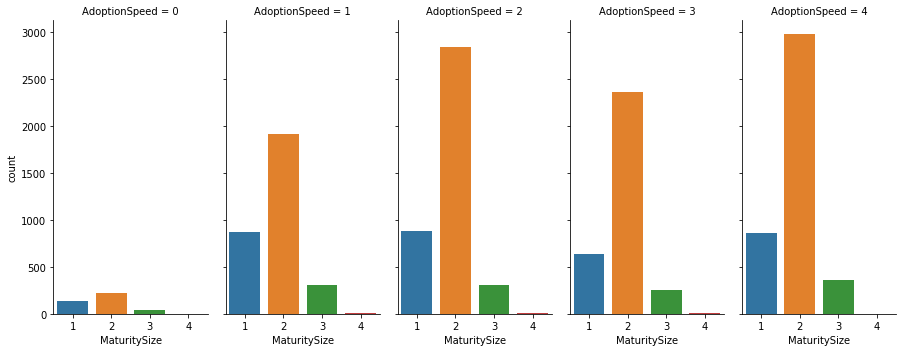

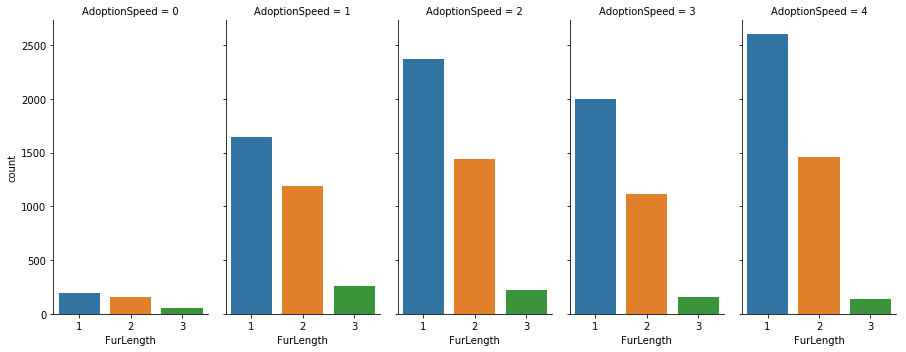

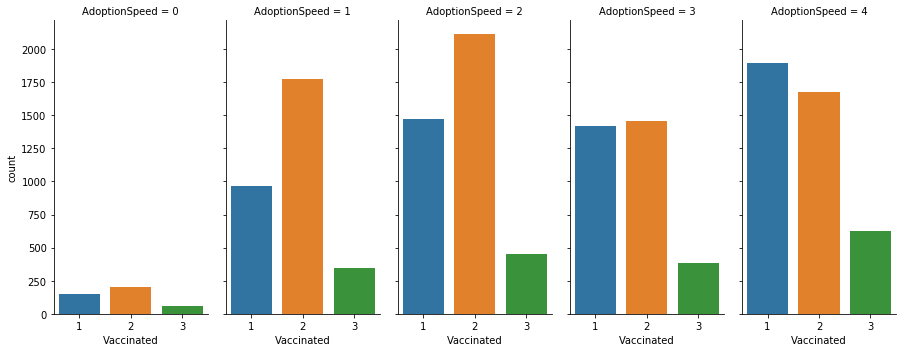

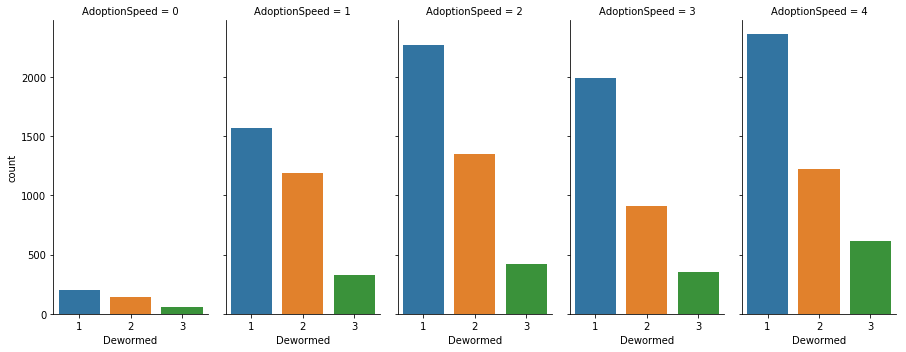

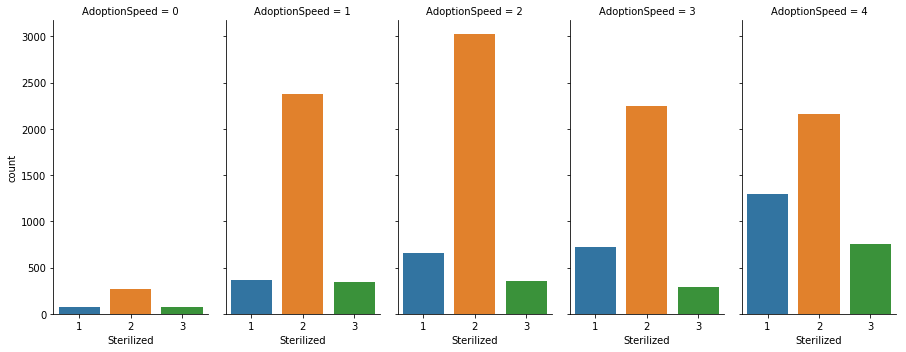

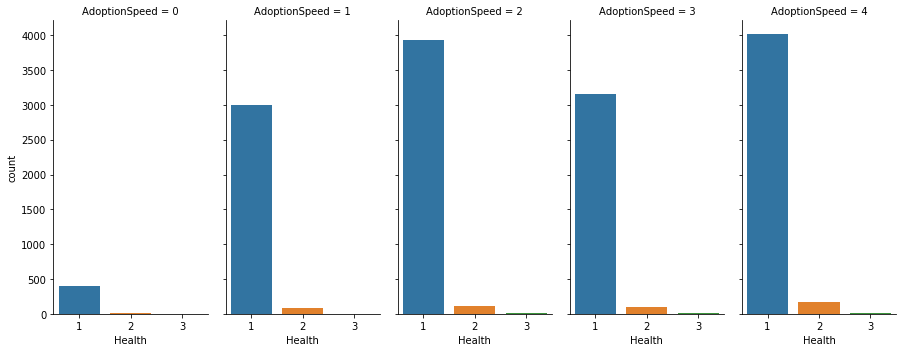

In [0]:
## investigate adoption speed across categorical variables
for n in range(8):
  sb.catplot(x=target.columns[n], col='AdoptionSpeed', data=target, kind='count', height=5, aspect=0.5)

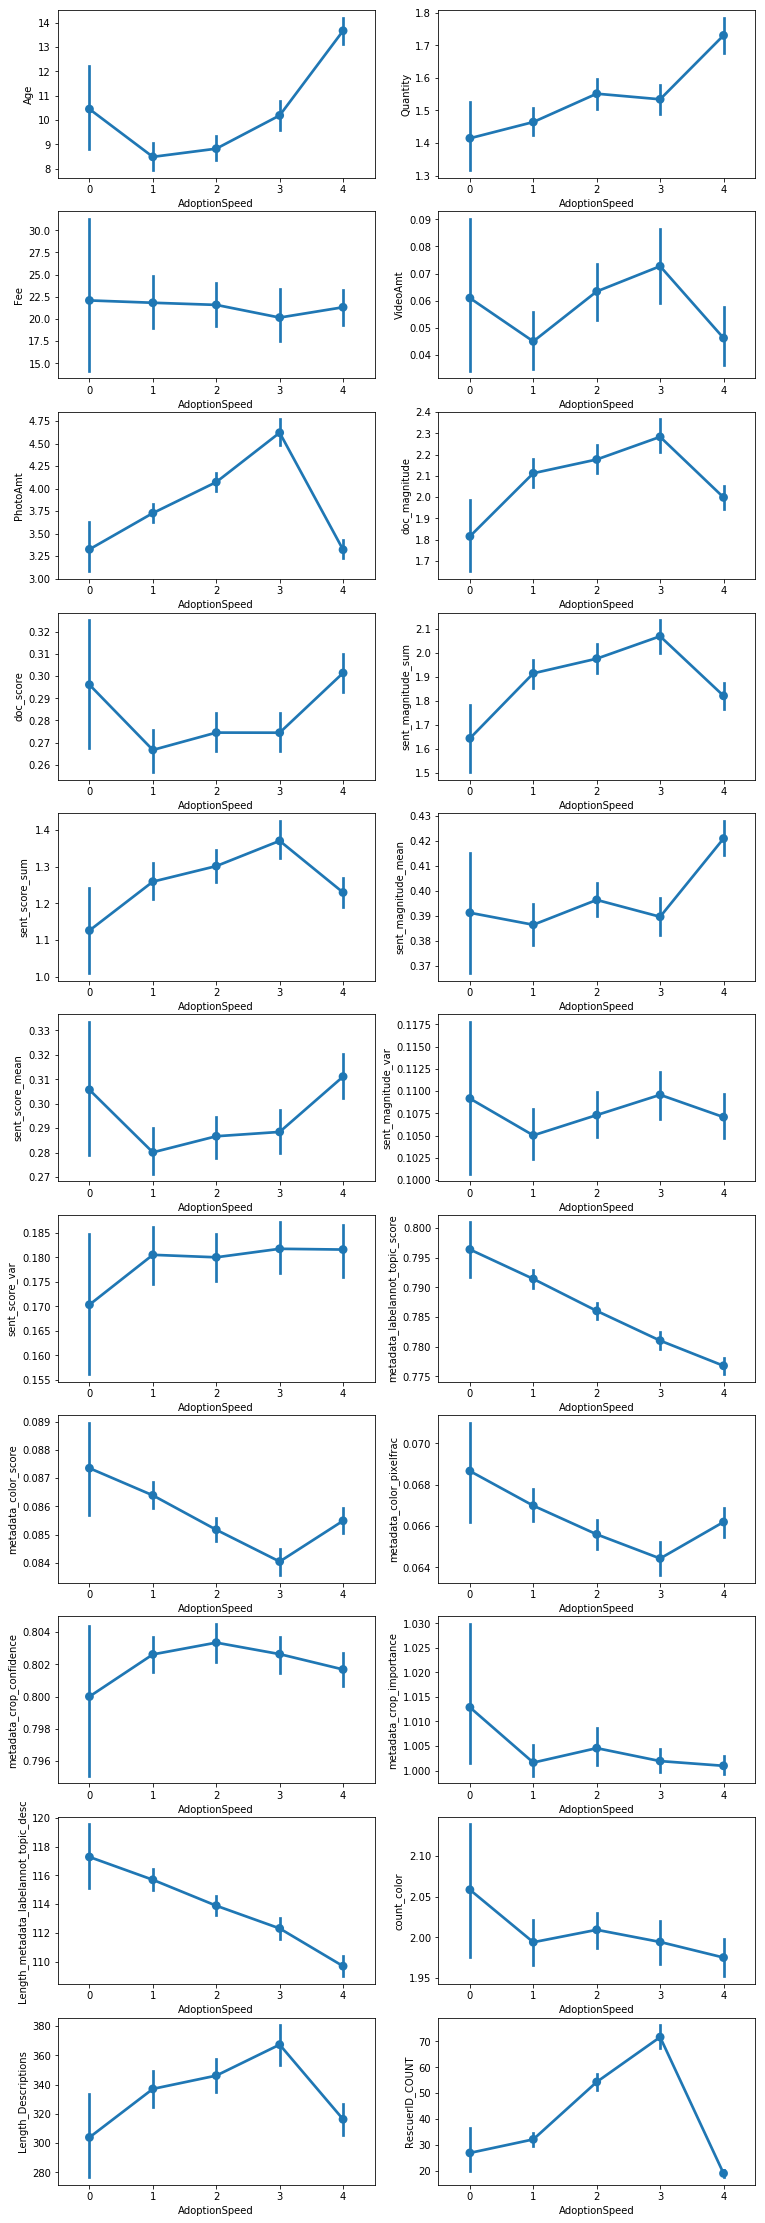

In [0]:
fig, axs = plt.subplots(nrows=11, ncols=2, figsize=(12.5,40))
r = 0
c = 0
for n in (i for j in (range(8,13), range(15,28), range(29,33)) for i in j):
  sb.catplot(x='AdoptionSpeed', y=target.columns[n], data=target, kind='point', ax=axs[r][c])
  c += 1
  if c == 2:
    c = 0
    r += 1
  plt.close(2)

In [0]:
## One-hot encoded categorical inputs
target_oh = pd.get_dummies(target[target.columns[0:8]])
target_oh = target_oh.drop(columns=['Vaccinated_3', 'Dewormed_3', 'Sterilized_3'])

## Target variable: Adoption Speed
## The speed was literally ordinally binned to 5 groups;
## hence 4 binary targets could be created to retain the ordinal nature
target_Y1 = target['AdoptionSpeed'].apply(lambda x: 0 if x==4 else 1)
target_Y2 = target['AdoptionSpeed'].apply(lambda x: 0 if x>2 else 1)
target_Y3 = target['AdoptionSpeed'].apply(lambda x: 0 if x>1 else 1)
target_Y4 = target['AdoptionSpeed'].apply(lambda x: 0 if x>0 else 1)
target_Y = pd.concat([target_Y1, target_Y2, target_Y3, target_Y4], axis=1)
target_Y.columns = ['within 90 days', 'within 30 days', 'within 7 days', 'Same day']

## All features from the base feature sets
target_X_pure = pd.concat([target_oh, breed_label, color_label, state, target[target.columns[8:13]], 
                           target[target.columns[15:28]], target[target.columns[29:]]], axis=1)

In [0]:
## Impute the missing cases for undefined variances
var_zero1 = []
var_zero2 = []
for y in range(len(target_X_pure)):
    if pd.isnull(target_X_pure['sent_score_sum'][y])==False and pd.isnull(target_X_pure['sent_score_var'][y])==True:
        var_zero1.append(0)
        var_zero2.append(0)
    else:
        var_zero1.append(target_X_pure['sent_magnitude_var'][y])
        var_zero2.append(target_X_pure['sent_score_var'][y])
        
target_X_pure['sent_magnitude_var'] = pd.Series(var_zero1)
target_X_pure['sent_score_var'] = pd.Series(var_zero2)

target_X_pure_miss = target_X_pure[target_X_pure.iloc[:,-22:].isnull().any(1)==True]
target_X_pure_nonmiss = target_X_pure[target_X_pure.iloc[:,-22:].isnull().any(1)==False]
target_X_pure.iloc[:,-22:].apply(lambda x: x.isna().sum())

Age                                        0
Quantity                                   0
Fee                                        0
VideoAmt                                   0
PhotoAmt                                   0
doc_magnitude                            551
doc_score                                551
sent_magnitude_sum                       551
sent_score_sum                           551
sent_magnitude_mean                      551
sent_score_mean                          551
sent_magnitude_var                       551
sent_score_var                           551
metadata_labelannot_topic_score          343
metadata_color_score                     341
metadata_color_pixelfrac                 341
metadata_crop_confidence                 341
metadata_crop_importance                 343
Length_metadata_labelannot_topic_desc    341
count_color                                0
Length_Descriptions                        0
RescuerID_COUNT                            0
dtype: int

In [0]:
## number of images with facial annotations
print(face_nonmiss.shape)
## number of images with more than 1 facial annotation
print(face_dup.shape)

(212, 13)
(23, 13)


In [0]:
## aggregate for facial annotations per pet ID
for n in face_nonmiss.columns[1:6]:
    face_nonmiss[n] = face_nonmiss[n].astype('float')
    
face_nonmiss_agg = face_nonmiss.groupby(['PetID']).agg(
                    {'facedata_rollAngle':['mean'], 'facedata_panAngle':['mean'], 
                     'facedata_tiltAngle':['mean'], 'facedata_detect_confidence':['max'],
                     'facedata_landmark_confidence':['max'], 'facedata_joyLikelihood':['max'],
                     'facedata_sorrowLikelihood':['max'], 'facedata_angerLikelihood':['max'],
                     'facedata_surpriseLikelihood':['max'], 'facedata_exposedLikelihood':['max'],
                     'facedata_blurredLikelihood':['max'], 'facedata_headwearLikelihood':['max']})

face_nonmiss_agg.columns = ['facedata_rollAngle_mean', 'facedata_panAngle_mean', 
                            'facedata_tiltAngle_mean', 'facedata_detect_confidence_max',
                            'facedata_landmark_confidence_max', 'facedata_joyLikelihood_max',
                            'facedata_sorrowLikelihood_max', 'facedata_angerLikelihood_max',
                            'facedata_surpriseLikelihood_max', 'facedata_exposedLikelihood_max',
                            'facedata_blurredLikelihood_max', 'facedata_headwearLikelihood_max']

In [0]:
## All features from the base feature sets + TFIDF matrix for pet descriptions
target_X_tfidf = pd.concat([target_X_pure, tfidf_doc_matrix], axis=1)
target_X_tfidf = pd.concat([target['PetID'], target_X_tfidf], axis=1)
target_X_tfidf = pd.concat([target_X_tfidf, metadata_label_annot_desc_tfidf_matrix], axis=1)

In [0]:
## All features from the base feature sets + Doc2Vec features for pet descriptions
target_X_d2v = pd.concat([target_X_pure, doc_v], axis=1)
target_X_d2v = pd.concat([target['PetID'], target_X_d2v], axis=1)
target_X_d2v = pd.concat([target_X_d2v, meta_doc_v], axis=1)

#### **Image Feature Extraction**

Following steps for image processing:
<ul>
<li>Standardize the image size and number of channels for exceptions in the dataset
  <ul><li>The distribution plots of image heights and image widths showed majority falling in the range of 400 to 600, <br>
        yet highly skewed with some being over 1000.</li>
      <li>Final chosen size was 400 x 400; <br>
        a squared shape might compress the image but favours convolutional operations to generate pooled output in downstream layers.</li>
      <li>Some images only have one channel (gray-colored scale); replicated to 3 channels</li></ul></li>
<li>Convolutional-Autoencoder
  <ul><li>Extract the intermediate flattened layer output for trained autoencoder; 10000 dimensions</li>
      <li>Other CNN-based models could be used for pre-training or transfer learning, e.g. Dense-Net</li></ul></li>
<li>NMF dimensionality reduction
  <ul><li>To avoid high complexity in boosting tree classification</li></ul></li>
<li>Soft Clustering all images by HDBSCAN
  <ul><li>Aggregated reduced image features per pet ID for a pet possibly having more than 1 image</li>
      <li>One-hot encoded cluster membership features</li></ul></li>

In [0]:
## process pet images
from torch.utils import data
## use pytorch data loader for reading image into arrays
class read_image_data(data.Dataset):
  def __init__(self, root_path, img_list):
    self.root_path = root_path
    self.img_list = img_list
  def __getitem__(self, index):
    imgID = self.img_list[index]
    image_path = os.path.join(self.root_path, imgID + '.jpg')
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    return image
  def __len__(self):
    return len(self.img_list)

image_list = [str(x).split('.')[0] for x in os.listdir('./train_images/')]
train_img_path = './train_images/'
train_img = read_image_data(train_img_path, image_list)

In [0]:
## check the size distributions of the images in the database
heights = [train_img[x].shape[0] for x in range(len(train_img))]
widths = [train_img[x].shape[1] for x in range(len(train_img))]

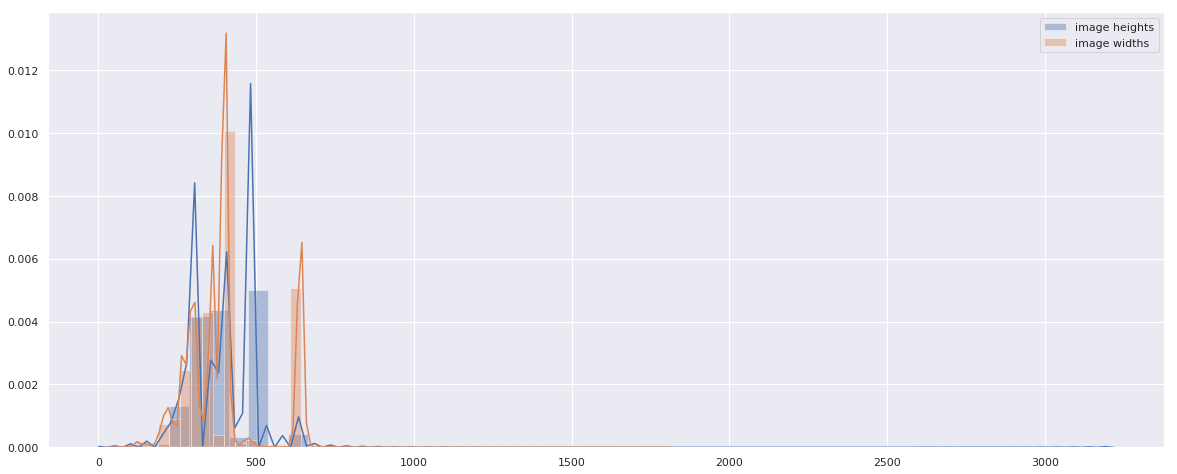

In [0]:
sb.set(rc={'figure.figsize':(20,8)})
sb.distplot(heights, label='image heights')
sb.distplot(widths, label='image widths')
plt.legend()
plt.show()

In [0]:
## resize and standardize the sizes for all images
from PIL import Image

new_width  = 400
new_height = 400

resized_train_dir = 'resized_train_images'
os.mkdir(resized_train_dir)

for img_item in os.listdir(train_img_path):
  img = Image.open(train_img_path + img_item)
  img = img.resize((new_width, new_height), Image.ANTIALIAS)
  img.save('./resized_train_images/' + 'resize_' + img_item)

In [0]:
resize_image_list = [str(x).split('.')[0] for x in os.listdir('./resized_train_images/')]
train_resize_img = read_image_data('./resized_train_images/', resize_image_list)

In [0]:
print('Resized image shape: ' + str(train_resize_img[0].shape))

Resized image shape: (400, 400, 3)


In [0]:
## check consistency in image number of channels
channel_check = []
for im in range(len(train_resize_img)):
  if len(train_resize_img[im].shape)!=3 or train_resize_img[im].shape[2]!=3:
    channel_check.append(im + 1)

In [0]:
for i in channel_check:
  print("Index: " + str(i-1) + " " + str(train_resize_img[i-1].shape))

Index: 473 (400, 400)
Index: 1527 (400, 400)
Index: 1650 (400, 400)
Index: 2770 (400, 400)
Index: 3680 (400, 400)
Index: 4350 (400, 400)
Index: 5544 (400, 400)
Index: 8613 (400, 400)
Index: 12763 (400, 400)
Index: 13456 (400, 400)
Index: 13458 (400, 400)
Index: 17293 (400, 400)
Index: 20712 (400, 400)
Index: 20823 (400, 400)
Index: 24045 (400, 400)
Index: 24691 (400, 400)
Index: 29509 (400, 400)
Index: 35240 (400, 400)
Index: 38789 (400, 400)
Index: 40834 (400, 400)
Index: 42866 (400, 400)
Index: 48241 (400, 400)
Index: 49692 (400, 400)
Index: 51829 (400, 400)
Index: 52058 (400, 400)
Index: 55178 (400, 400)
Index: 55868 (400, 400)
Index: 57740 (400, 400)


In [0]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

In [0]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2))
        
        class Flatten(torch.nn.Module):
          def forward(self, x):
            batch_size = x.shape[0]
            return x.view(batch_size, -1)
          
        self.flatten = Flatten()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 3, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Tanh())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
## device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_autoencoder = CNN_Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_autoencoder.parameters(), weight_decay=0.0001)

In [0]:
## Do 6 splits for all 58,311 image samples
def train_by_batch(batch):
  num_epochs = 1
  batch_size = 50
  split_size = 10000
  num_batch = int(split_size / batch_size)
  pointer = (batch - 1)*10000

  for b in range(num_batch): 
    train_x_array = []
    for s in range(batch_size):
      if pointer + s + 1 in channel_check:
        train_x_array.append(np.stack((train_resize_img[pointer + s],)*3, axis=-1))
      else:
        train_x_array.append(train_resize_img[pointer + s])
      if pointer + s + 1 >= len(train_resize_img):
        break

    train_X = np.array(train_x_array, dtype=np.uint8)
    train_X = torch.from_numpy(train_X / 255.0).float()
    train_X = Variable(train_X)
    train_X = train_X.transpose(1, 3)

    for ep in range(num_epochs):
      output = cnn_autoencoder(train_X)
      loss = distance(output, train_X)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print('batch [{}/{}] epoch [{}/{}], loss:{:.4f}'.format(b + 1, num_batch, ep + 1, num_epochs, loss))

    pointer += batch_size
    if pointer >= len(train_resize_img):
      break

  torch.save({'epoch': num_epochs + 1, 'state_dict': cnn_autoencoder.state_dict(),
              'optimizer': optimizer.state_dict(), 'loss': loss, }, F'/content/drive/My Drive/Colab Notebooks/cnn_autoencoder_' + str(batch) + '.pt')

In [0]:
## history of the 6th (last) batch training
train_by_batch(6)

batch [1/200] epoch [1/1], loss:0.0056
batch [2/200] epoch [1/1], loss:0.0046
batch [3/200] epoch [1/1], loss:0.0050
batch [4/200] epoch [1/1], loss:0.0063
batch [5/200] epoch [1/1], loss:0.0061
batch [6/200] epoch [1/1], loss:0.0066
batch [7/200] epoch [1/1], loss:0.0079
batch [8/200] epoch [1/1], loss:0.0061
batch [9/200] epoch [1/1], loss:0.0067
batch [10/200] epoch [1/1], loss:0.0059
batch [11/200] epoch [1/1], loss:0.0059
batch [12/200] epoch [1/1], loss:0.0061
batch [13/200] epoch [1/1], loss:0.0065
batch [14/200] epoch [1/1], loss:0.0060
batch [15/200] epoch [1/1], loss:0.0055
batch [16/200] epoch [1/1], loss:0.0057
batch [17/200] epoch [1/1], loss:0.0053
batch [18/200] epoch [1/1], loss:0.0075
batch [19/200] epoch [1/1], loss:0.0055
batch [20/200] epoch [1/1], loss:0.0063
batch [21/200] epoch [1/1], loss:0.0052
batch [22/200] epoch [1/1], loss:0.0065
batch [23/200] epoch [1/1], loss:0.0063
batch [24/200] epoch [1/1], loss:0.0061
batch [25/200] epoch [1/1], loss:0.0061
batch [26

In [0]:
## load pytorch model checkpoint after completing training
checkpoint = torch.load(F'/content/drive/My Drive/Colab Notebooks/cnn_autoencoder_6.pt')
cnn_autoencoder.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [0]:
## extract flattened latent dimensions of image features from pre-trained CNN autoencoder
cnn_auto_image_embedding = nn.Sequential(*list(cnn_autoencoder.children())[:-1]).cpu()

In [0]:
from torchsummary import summary
summary(cnn_autoencoder, input_size=(3, 400, 400), device="cpu")
summary(cnn_auto_image_embedding, input_size=(3, 400, 400), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 400, 400]           3,584
              ReLU-2        [-1, 128, 400, 400]               0
         MaxPool2d-3        [-1, 128, 200, 200]               0
            Conv2d-4         [-1, 64, 200, 200]          73,792
              ReLU-5         [-1, 64, 200, 200]               0
         MaxPool2d-6         [-1, 64, 100, 100]               0
            Conv2d-7         [-1, 32, 100, 100]          18,464
              ReLU-8         [-1, 32, 100, 100]               0
         MaxPool2d-9           [-1, 32, 50, 50]               0
           Conv2d-10           [-1, 16, 50, 50]           4,624
             ReLU-11           [-1, 16, 50, 50]               0
        MaxPool2d-12           [-1, 16, 25, 25]               0
  ConvTranspose2d-13           [-1, 32, 25, 25]           4,640
             ReLU-14           [-1, 32,

In [0]:
## generate encoded latent dimensions
cnn_auto_image_embedding.eval()
pred = []
for enc in range(len(train_resize_img)):
  if enc + 1 in channel_check:
    test_X = np.stack((train_resize_img[enc],)*3, axis=-1)
  else:
    test_X = train_resize_img[enc]

  test_X = np.array(test_X, dtype=np.uint8)
  test_X = torch.from_numpy(test_X / 255.0).float()
  test_X = Variable(test_X)
  test_X = test_X.view(1, 400, 400, 3)
  test_X = test_X.transpose(1, 3)
  
  decode_dim = cnn_auto_image_embedding(test_X)
  decode_dim = decode_dim.cpu().detach().numpy()
  pred.append(decode_dim)

In [0]:
## transform to dataframe and mapping petID
img_latent_dim = pd.DataFrame(np.concatenate(pred))

img_name = [re.split(r'[_-]', x)[1] for x in resize_image_list]
img_latent_dim = pd.concat([pd.Series(img_name), img_latent_dim], axis=1)

dim_col = []
for i in range(10000):
  dim_col.append('img_latent_dim' + str(i+1))

img_latent_dim.columns = ['PetID'] + dim_col

In [0]:
img_latent_dim.iloc[0:10, 0:10]

,PetID,img_latent_dim1,img_latent_dim2,img_latent_dim3,img_latent_dim4,img_latent_dim5,img_latent_dim6,img_latent_dim7,img_latent_dim8,img_latent_dim9
0,5d9a6398d,0.139896,0.207225,0.259924,0.277131,0.330290,0.264793,0.202345,0.268200,0.263133
1,99c2ceb33,0.201788,0.129552,0.202266,0.218302,0.203100,0.175980,0.464590,0.549718,0.286482
2,0178fe2f7,0.216532,0.153842,0.283746,0.286401,0.477494,0.545170,0.467537,0.465367,0.311124
3,8940dfe55,0.335050,0.492344,0.319492,0.119220,0.116059,0.246591,0.282018,0.324943,0.192910
4,716167b76,0.243373,0.304940,0.381703,0.546111,0.453937,0.442563,0.453184,0.296356,0.290595
5,243aaaf6c,0.194675,0.167946,0.178646,0.333387,0.099614,0.135451,0.217329,0.110917,0.041030
6,8cb6dfa5b,0.124045,0.042951,0.067646,0.128197,0.160697,0.156150,0.153667,0.189162,0.052010
7,81d6d070c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,094636517,0.349045,0.351312,0.272066,0.328780,0.326444,0.319297,0.330930,0.341595,0.307309
9,128b247b8,0.306052,0.360335,0.000000,0.131313,0.382168,0.431612,0.763905,0.395603,0.281611


In [0]:
## convert to sparse matrix format to avoid memory issues
from scipy import sparse
Arr_img_latent_dim = sparse.csr_matrix(np.array(img_latent_dim.iloc[:,1:]))

In [0]:
## do NMF to reduce the dimensionality
from sklearn.decomposition import NMF
nmf = NMF(n_components=100, solver='mu', max_iter=100, random_state=0, verbose=True).fit(Arr_img_latent_dim)

Epoch 10 reached after 658.758 seconds, error: 4613.918223
Epoch 20 reached after 1291.521 seconds, error: 4395.514149
Epoch 30 reached after 1924.842 seconds, error: 4273.258900
Epoch 40 reached after 2553.723 seconds, error: 4190.027184
Epoch 50 reached after 3182.537 seconds, error: 4129.439866
Epoch 60 reached after 3809.564 seconds, error: 4084.250571
Epoch 70 reached after 4440.899 seconds, error: 4050.363035
Epoch 80 reached after 5071.688 seconds, error: 4024.738819
Epoch 90 reached after 5703.169 seconds, error: 4005.097674
Epoch 100 reached after 6333.990 seconds, error: 3989.816895


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/nmf.py:1069: ConvergenceWarning: Maximum number of iteration 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [0]:
reduced_img_latent_dim = nmf.transform(Arr_img_latent_dim)

Epoch 10 reached after 89.781 seconds, error: 4241.479741
Epoch 20 reached after 120.330 seconds, error: 4016.115247
Epoch 30 reached after 150.911 seconds, error: 3936.806335
Epoch 40 reached after 181.543 seconds, error: 3898.761337
Epoch 50 reached after 211.836 seconds, error: 3877.493253
Epoch 60 reached after 242.187 seconds, error: 3864.434741
Epoch 70 reached after 272.301 seconds, error: 3855.882141
Epoch 80 reached after 302.937 seconds, error: 3850.006120
Epoch 90 reached after 333.347 seconds, error: 3845.815872
Epoch 100 reached after 363.781 seconds, error: 3842.736858


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/nmf.py:1069: ConvergenceWarning: Maximum number of iteration 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [0]:
reduced_img_latent_dim.shape

(58311, 100)

In [0]:
## In case of multiple images existed per PetID; 
## Average aggregate the reduced dimensions as feature representations
reduced_img_latent_dim = pd.concat([img_latent_dim.iloc[:,0], reduced_img_latent_dim], axis=1)
reduced_img_latent_dim_agg = reduced_img_latent_dim.groupby(['PetID']).mean()
reduced_img_latent_dim_agg.reset_index(inplace=True)

In [0]:
mean_agg_dim_col = []
for i in range(100):
  mean_agg_dim_col.append('mean_agg_img_dim' + str(i+1))
reduced_img_latent_dim_agg.columns = ['PetID'] + mean_agg_dim_col

In [0]:
reduced_img_latent_dim_agg.shape

(14652, 101)

In [0]:
## In case of multiple images existed per PetID; 
## simple mean / max aggregation of values for each image latent feature by petID might not make sense;
## do an image clustering on the convolved pixel values to infer a grouping representation of image features
!pip install hdbscan
from hdbscan import HDBSCAN
cluster = HDBSCAN(min_cluster_size=3, prediction_data=True).fit(reduced_img_latent_dim)

In [0]:
## soften the clustering to get the probabilities
from hdbscan import all_points_membership_vectors
soft_clusters = all_points_membership_vectors(cluster)

In [0]:
soft_clusters = pd.read_csv(F'drive/My Drive/soft_clusters.csv')
soft_clusters = soft_clusters.drop([soft_clusters.columns[0]], axis=1)

In [0]:
## filling NaN predicted probabilities (noise points / outliers)
soft_clusters = soft_clusters.fillna(0)

In [0]:
soft_clusters.shape

(58311, 773)

In [0]:
## max aggregation on the cluster probabilities for multiple images per ID
img_cluster_dim = pd.concat([img_latent_dim.iloc[:,0], soft_clusters], axis=1)
img_cluster_agg = img_cluster_dim.groupby(['PetID']).max()
img_cluster_agg.reset_index(inplace=True)

In [0]:
max_agg_dim_col = []
for i in range(773):
  max_agg_dim_col.append('max_prob_img_cluster' + str(i+1))
img_cluster_agg.columns = ['PetID'] + max_agg_dim_col

In [0]:
img_cluster_agg.shape

(14652, 774)

In [0]:
## All features from the base feature sets + TFIDF matrix for pet descriptions + face annotations (if any)
target_X_all_tfidf = target_X_tfidf.merge(face_nonmiss_agg, 
                                          left_on='PetID', right_on='PetID', how='left')
target_X_all_tfidf['isFacical'] = target_X_all_tfidf['facedata_detect_confidence_max'].apply(
                                                                lambda x: 1 if x!=np.nan else 0)

target_X_all_tfidf = target_X_all_tfidf.merge(reduced_img_latent_dim_agg, 
                                              left_on='PetID', right_on='PetID', how='left')
target_X_all_tfidf = target_X_all_tfidf.merge(img_cluster_agg, 
                                              left_on='PetID', right_on='PetID', how='left')

## re-mapping the target
target_X_all_tfidf = target_X_all_tfidf.merge(target[['AdoptionSpeed', 'PetID']], 
                                              left_on='PetID', right_on='PetID', how='left')

In [0]:
## All features from the base feature sets + Doc2Vec features for pet descriptions + face annotations (if any)
target_X_all_d2v = target_X_d2v.merge(face_nonmiss_agg, 
                                      left_on='PetID', right_on='PetID', how='left')
target_X_all_d2v['isFacical'] = target_X_all_d2v['facedata_detect_confidence_max'].apply(
                                                            lambda x: 1 if x!=np.nan else 0)

target_X_all_d2v = target_X_all_d2v.merge(reduced_img_latent_dim_agg, 
                                          left_on='PetID', right_on='PetID', how='left')
target_X_all_d2v = target_X_all_d2v.merge(img_cluster_agg, 
                                          left_on='PetID', right_on='PetID', how='left')

## re-mapping the target
target_X_all_d2v = target_X_all_d2v.merge(target[['AdoptionSpeed', 'PetID']], 
                                          left_on='PetID', right_on='PetID', how='left')

In [0]:
## concatenating with the target
target_X_pure = pd.concat([target_X_pure, target['AdoptionSpeed'], target_Y], axis=1)

In [0]:
## re-create binary targets from ordinal adoption speeds due to a change in number of rows after merging with the face annotations
target_X_all_tfidf['within 90 days'] = target_X_all_tfidf['AdoptionSpeed'].apply(lambda x: 0 if x==4 else 1)
target_X_all_tfidf['within 30 days'] = target_X_all_tfidf['AdoptionSpeed'].apply(lambda x: 0 if x>2 else 1)
target_X_all_tfidf['within 7 days'] = target_X_all_tfidf['AdoptionSpeed'].apply(lambda x: 0 if x>1 else 1)
target_X_all_tfidf['Same day'] = target_X_all_tfidf['AdoptionSpeed'].apply(lambda x: 0 if x>0 else 1)
target_X_all_tfidf = target_X_all_tfidf.iloc[:, target_X_all_tfidf.columns!='PetID']

target_X_all_d2v['within 90 days'] = target_X_all_d2v['AdoptionSpeed'].apply(lambda x: 0 if x==4 else 1)
target_X_all_d2v['within 30 days'] = target_X_all_d2v['AdoptionSpeed'].apply(lambda x: 0 if x>2 else 1)
target_X_all_d2v['within 7 days'] = target_X_all_d2v['AdoptionSpeed'].apply(lambda x: 0 if x>1 else 1)
target_X_all_d2v['Same day'] = target_X_all_d2v['AdoptionSpeed'].apply(lambda x: 0 if x>0 else 1)
target_X_all_d2v = target_X_all_d2v.iloc[:, target_X_all_d2v.columns!='PetID']

In [0]:
print(target_X_pure.shape)
print(target_X_all_tfidf.shape)
print(target_X_all_d2v.shape)

(14993, 377)
(14993, 8756)
(14993, 2263)


In [0]:
## print target vectors
target_X_pure.iloc[:,-4:]

,within 90 days,within 30 days,within 7 days,Same day
0,1,1,0,0
1,1,1,1,1
2,1,0,0,0
3,1,1,0,0
4,1,1,0,0
...,...,...,...,...
14988,1,1,0,0
14989,0,0,0,0
14990,1,0,0,0
14991,0,0,0,0


#### Model Training

Gradient Boosting and XGBoost algorithms have been widely adopted in competitions for their robustness on achieving high score. Quadratically-weighted Cohen's Kappa score was the assigned evaluation metric in this pet adoption speed prediction contest. It measures the degree of agreement between the ratings or votes between two individuals. The optimized cut-off thresholds of predicted probabilities of the classes were referred to the winning solution on Kaggle: https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773


The top competitors had achieved a score of around 0.43 to 0.46 in general. The IPython Notebook did not emphasize on the quality-evaluation and selection of the engineered features, and had not used some of the external features like the geographical and demographic variations of the pet owners, local promotions and web search data, etc. as suggested by the winning solutions.


The main focus was to test the outcome and performance of using the afore-mentioned ordinal-encoded target feature, while creating outlier-based features and reconstructing the training set with resampling algorithms. Bechnmarking on the Gradient Boosting classifier in LightGBM implementation, the breakdown Cohen's Kappa scores for each class were not consistently close, for relatively rare classes ("Same day" adoption, "Within 7 day" adoption and "No adoption within 90 days"), the model was hard to be claimed a successful one. 


In [0]:
## Defining Cohen's Kappa (target metrics quantifying the results of this competition)

def construct_confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  
    Potential values range from -1 (representing complete disagreement) to 1 (representing complete agreement).  
    A kappa value of 0 is expected if all agreement is due to chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b each correspond to a list of integer ratings.  
    These lists must have the same length, and the ratings should be integers, 
    and it is assumed that they contain the complete range of possible ratings.
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = construct_confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

from functools import partial
import scipy as sp

## Optimized cut-offs for distinguishing classes of adoption speeds
#### for 4 classes:
class OptimizedRounder1(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

## for binary classes:
class OptimizedRounder2(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [0]:
## function for plotting confusion matrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion(y_true, y_pred):
  cfs_mat = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cfs_mat, columns=np.unique(y_true), index = np.unique(y_true))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (6,4))
  sb.set(font_scale=1)
  sb.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 10}, fmt="d")

In [0]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=8, random_state=42)

In [0]:
## Setting A):
## multi-label ordinal settings of 4 binary columns:
## 'within 90 days'; 'within 30 days'; 'within 7 days'; 'Same day'

## Setting B):
## multi-class settings of discrete class

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb

class boosting_ensemble_models:
  def __init__(self, train_set):
    self.target_X = train_set
    self.target_X = self.target_X.fillna(-99)
    self.target_X = self.target_X.apply(pd.to_numeric)
    
  def train_test_split_for_multi_label(self, target_X):
    train_X_class, test_X_class, train_y_class, test_y_class = train_test_split(
          target_X.iloc[:,0:target_X.shape[1]-5], 
          target_X.iloc[:,target_X.shape[1]-4:target_X.shape[1]],
          stratify = target_X.iloc[:,target_X.shape[1]-4:target_X.shape[1]],
          test_size=3/11, shuffle=True, random_state=42)
    
    train_X_reg, test_X_reg, train_y_reg, test_y_reg = train_test_split(
          target_X.iloc[:,0:target_X.shape[1]-5],  
          target_X.iloc[:,target_X.shape[1]-5],
          stratify = target_X.iloc[:,target_X.shape[1]-5], 
          test_size=3/11, shuffle=True, random_state=42)
    return train_X_class, test_X_class, train_y_class, test_y_class, 
            train_X_reg, test_X_reg, train_y_reg, test_y_reg
  
  def define_LGB(self):
    GB_class = lgb.LGBMClassifier(boosting_type='gbdt', objective='cross_entropy', num_iterations=1000,
                                  n_estimators=300, learning_rate=0.001, num_leaves=150, max_depth=100, 
                                  n_jobs=4, min_data_in_leaf=10, unbalance=True, random_state=42,
                                  lambda_l1=0.1, lambda_l2=0.01)
    GB_regress = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', num_iterations=1000,
                                   n_estimators=300, learning_rate=0.001, num_leaves=150, max_depth=100, 
                                   n_jobs=4, min_data_in_leaf=10, unbalance=True, random_state=42,
                                   lambda_l1=0.1, lambda_l2=0.01)
    return GB_class, GB_regress
  
  def define_XGB(self):
    XGB_class = xgb.XGBClassifier(n_estimators=300, learning_rate=0.01, max_depth=150, verbosity=1, 
                                  n_jobs=4, reg_alpha=0.1, reg_lambda=0.01, random_state=42)
    XGB_regress = xgb.XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=150, verbosity=1, 
                                   n_jobs=4, reg_alpha=0.1, reg_lambda=0.01, random_state=42)
    return XGB_class, XGB_regress
  
  def training_process(self, train_X_class, test_X_class, train_y_class, test_y_class, 
                       train_X_reg, test_X_reg, train_y_reg, test_y_reg,
                       classifier, regressor):
    predict_reg = []
    importance_reg = []
    qwck_reg = []
    optR1 = OptimizedRounder1()

    for train_index, test_index in skf.split(train_X_reg, train_y_reg):
        X_train, X_val = train_X_reg.iloc[train_index], train_X_reg.iloc[test_index]
        y_train, y_val = train_y_reg.iloc[train_index], train_y_reg.iloc[test_index]

        reg_ = regressor.fit(X_train, y_train, eval_metric=['mae'],
                             eval_set=[(X_val, y_val)], verbose = True)

    predict_reg.append(reg_.predict(test_X_reg))
    importance_reg.append(pd.DataFrame(sorted(zip(reg_.feature_importances_, train_X_reg.columns)), 
                                       columns=['Value','Feature']))
    optR1.fit(predict_reg[0], test_y_reg)
    coefficients = optR1.coefficients()
    cutoff_reg = optR1.predict(predict_reg[0], coefficients)
    qwck_reg.append(quadratic_weighted_kappa(test_y_reg.values, cutoff_reg))
    
    predict_class = []
    importance_class = []
    qwck_class = []
    optR2 = OptimizedRounder2()

    for i in range(4):
        for train_index, test_index in skf.split(train_X_class, train_y_class.iloc[:,i]):
            X_train, X_val = train_X_class.iloc[train_index], train_X_class.iloc[test_index]
            y_train, y_val = train_y_class.iloc[train_index, i], train_y_class.iloc[test_index, i]

            class_ = classifier.fit(X_train, y_train, eval_metric=['auc'],
                                    eval_set=[(X_val, y_val)], verbose = True)

        predict_class.append(class_.predict(test_X_class))
        importance_class.append(pd.DataFrame(sorted(zip(class_.feature_importances_, 
                                                        train_X_class.columns)), 
                                             columns=['Value','Feature']))
        optR2.fit(predict_class[i], test_y_class.iloc[:,i].values)
        coefficients = optR2.coefficients()
        cutoff_class = optR2.predict(predict_class[i], coefficients)
        qwck_class.append(quadratic_weighted_kappa(test_y_class.iloc[:,i].values, cutoff_class))

    return reg_, class_, predict_reg, predict_class, importance_reg, importance_class, 
            qwck_reg, qwck_class, cutoff_reg, cutoff_class
  
  def fit_lgb(self):
    self.train_X_class, self.test_X_class, self.train_y_class, self.test_y_class, \
    self.train_X_reg, self.test_X_reg, self.train_y_reg, self.test_y_reg \
    = self.train_test_split_for_multi_label(self.target_X)
    self.GB_class, self.GB_regress = self.define_LGB()
    return self.training_process(
        self.train_X_class, self.test_X_class, self.train_y_class, self.test_y_class,
        self.train_X_reg, self.test_X_reg, self.train_y_reg, self.test_y_reg,
        self.GB_class, self.GB_regress)
  
  def fit_xgb(self):
    self.train_X_class, self.test_X_class, self.train_y_class, self.test_y_class, \
    self.train_X_reg, self.test_X_reg, self.train_y_reg, self.test_y_reg \
    = self.train_test_split_for_multi_label(self.target_X)
    self.XGB_class, self.XGB_regress = self.define_XGB()
    return self.training_process(
        self.train_X_class, self.test_X_class, self.train_y_class, self.test_y_class,
        self.train_X_reg, self.test_X_reg, self.train_y_reg, self.test_y_reg,
        self.XGB_class, self.XGB_regress)

In [0]:
train_X_class, test_X_class, train_y_class, test_y_class, \
train_X_reg, test_X_reg, train_y_reg, test_y_reg \
= boosting_ensemble_models(target_X_pure).train_test_split_for_multi_label(target_X_pure)

In [0]:
## base features
reg_gbt1, class_gbt1, predict_reg_gbt1, predict_class_gbt1, importance_reg_gbt1, importance_class_gbt1, \
qwck_reg_gbt1, qwck_class_gbt1, cutoff_reg_1, cutoff_class_1 \
= boosting_ensemble_models(target_X_pure).fit_lgb()

In [0]:
## 1000 iterations, 300 estimators, 150 leaves, 100 max depth
print("Quad-weighted Cohen Kappa (regressor on multiclass target): " + '%.4f' % qwck_reg_gbt1[0])
print("Quad-weighted Cohen Kappa (classifier on binary multilabel targets): \n" + 
      "Within 90 days : " + '%.4f' % qwck_class_gbt1[0] + 
      "\nWithin 30 days : " + '%.4f' % qwck_class_gbt1[1] + 
      "\nWithin 7 days : " + '%.4f' % qwck_class_gbt1[2] +
      "\nWithin 1 day : " + '%.4f' % qwck_class_gbt1[3])

Quad-weighted Cohen Kappa (regressor on multiclass target): 0.2330
Quad-weighted Cohen Kappa (classifier on binary multilabel targets): 
Within 90 days : 0.2410
Within 30 days : 0.2752
Within 7 days : 0.0165
Within 1 day : 0.0172


In [0]:
print(classification_report(test_y_reg, cutoff_reg_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.00      0.00      0.00       843
           2       0.31      0.70      0.43      1101
           3       0.19      0.35      0.25       889
           4       0.00      0.00      0.00      1144

    accuracy                           0.26      4089
   macro avg       0.10      0.21      0.14      4089
weighted avg       0.13      0.26      0.17      4089



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
for i in range(4):
  print(classification_report(test_y_class.iloc[:,i].values, predict_class_gbt1[i]))

              precision    recall  f1-score   support

           0       0.70      0.23      0.35      1144
           1       0.76      0.96      0.85      2945

    accuracy                           0.76      4089
   macro avg       0.73      0.60      0.60      4089
weighted avg       0.75      0.76      0.71      4089

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      2033
           1       0.63      0.68      0.65      2056

    accuracy                           0.64      4089
   macro avg       0.64      0.64      0.64      4089
weighted avg       0.64      0.64      0.64      4089

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3134
           1       0.50      0.02      0.03       955

    accuracy                           0.77      4089
   macro avg       0.63      0.51      0.45      4089
weighted avg       0.71      0.77      0.67      4089

              preci

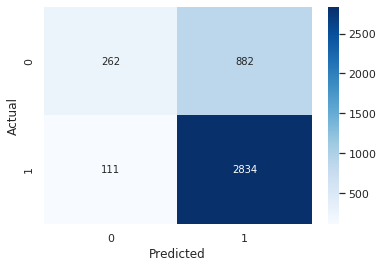

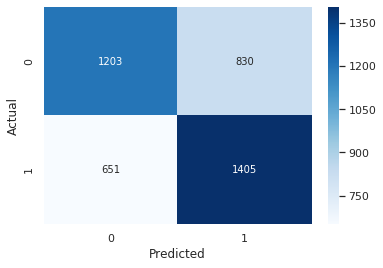

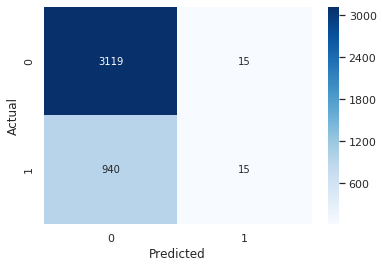

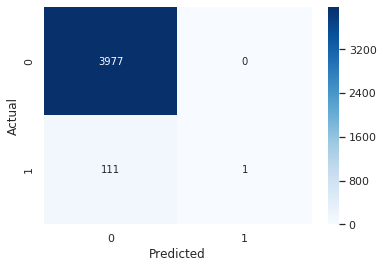

In [0]:
for i in range(4):
  plot_confusion(test_y_class.iloc[:,i].values, predict_class_gbt1[i])

In [0]:
## base features + tfidf + image_features
reg_gbt2, class_gbt2, predict_reg_gbt2, predict_class_gbt2, importance_reg_gbt2, importance_class_gbt2, \
qwck_reg_gbt2, qwck_class_gbt2, cutoff_reg_2, cutoff_class_2 \
= boosting_ensemble_models(target_X_all_tfidf).fit_lgb()

In [0]:
print("Quad-weighted Cohen Kappa (regressor on multiclass target): " + '%.4f' % qwck_reg_gbt2[0])
print("Quad-weighted Cohen Kappa (classifier on binary multilabel targets): \n" + 
      "Within 90 days : " + '%.4f' % qwck_class_gbt2[0] + 
      "\nWithin 30 days : " + '%.4f' % qwck_class_gbt2[1] + 
      "\nWithin 7 days : " + '%.4f' % qwck_class_gbt2[2] +
      "\nWithin 1 day : " + '%.4f' % qwck_class_gbt2[3])

Quad-weighted Cohen Kappa (regressor on multiclass target): 0.2115
Quad-weighted Cohen Kappa (classifier on binary multilabel targets): 
Within 90 days : 0.1588
Within 30 days : 0.2597
Within 7 days : 0.0096
Within 1 day : 0.0172


In [0]:
print(classification_report(test_y_reg, cutoff_reg_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.00      0.00      0.00       843
           2       0.31      0.66      0.43      1101
           3       0.20      0.39      0.26       889
           4       0.00      0.00      0.00      1144

    accuracy                           0.26      4089
   macro avg       0.10      0.21      0.14      4089
weighted avg       0.13      0.26      0.17      4089



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
for i in range(4):
  print(classification_report(test_y_class.iloc[:,i].values, predict_class_gbt2[i]))

              precision    recall  f1-score   support

           0       0.69      0.15      0.24      1144
           1       0.75      0.97      0.85      2945

    accuracy                           0.74      4089
   macro avg       0.72      0.56      0.54      4089
weighted avg       0.73      0.74      0.68      4089

              precision    recall  f1-score   support

           0       0.63      0.60      0.62      2033
           1       0.63      0.66      0.64      2056

    accuracy                           0.63      4089
   macro avg       0.63      0.63      0.63      4089
weighted avg       0.63      0.63      0.63      4089

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3134
           1       1.00      0.01      0.01       955

    accuracy                           0.77      4089
   macro avg       0.88      0.50      0.44      4089
weighted avg       0.82      0.77      0.67      4089

              preci

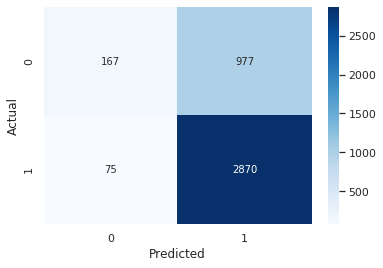

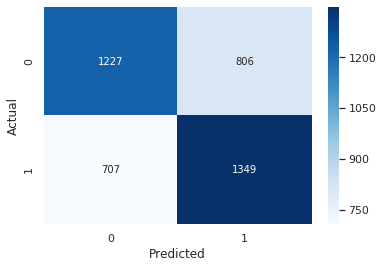

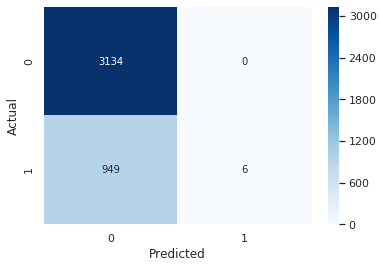

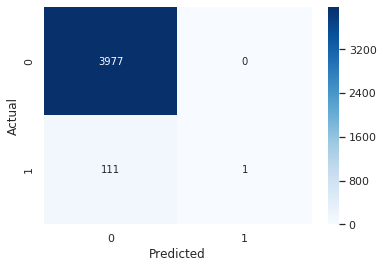

In [0]:
for i in range(4):
  plot_confusion(test_y_class.iloc[:,i].values, predict_class_gbt2[i])

In [0]:
## base features + doc2vec + image_features
reg_gbt3, class_gbt3, predict_reg_gbt3, predict_class_gbt3, importance_reg_gbt3, importance_class_gbt3, \
qwck_reg_gbt3, qwck_class_gbt3, cutoff_reg_3, cutoff_class_3 \
= boosting_ensemble_models(target_X_all_d2v).fit_lgb()

In [0]:
print("Quad-weighted Cohen Kappa (regressor on multiclass target): " + '%.4f' % qwck_reg_gbt3[0])
print("Quad-weighted Cohen Kappa (classifier on binary multilabel targets): \n" + 
      "Within 90 days : " + '%.4f' % qwck_class_gbt3[0] + 
      "\nWithin 30 days : " + '%.4f' % qwck_class_gbt3[1] + 
      "\nWithin 7 days : " + '%.4f' % qwck_class_gbt3[2] +
      "\nWithin 1 day : " + '%.4f' % qwck_class_gbt3[3])

Quad-weighted Cohen Kappa (regressor on multiclass target): 0.3390
Quad-weighted Cohen Kappa (classifier on binary multilabel targets): 
Within 90 days : 0.2917
Within 30 days : 0.2657
Within 7 days : 0.0579
Within 1 day : 0.0000


In [0]:
print(classification_report(test_y_reg, cutoff_reg_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.31      0.35      0.33       843
           2       0.29      0.31      0.30      1101
           3       0.25      0.27      0.26       889
           4       0.54      0.48      0.50      1144

    accuracy                           0.35      4089
   macro avg       0.28      0.28      0.28      4089
weighted avg       0.35      0.35      0.35      4089



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
for i in range(4):
  print(classification_report(test_y_class.iloc[:,i].values, predict_class_gbt3[i]))

              precision    recall  f1-score   support

           0       0.63      0.32      0.42      1144
           1       0.78      0.93      0.85      2945

    accuracy                           0.76      4089
   macro avg       0.71      0.62      0.64      4089
weighted avg       0.74      0.76      0.73      4089

              precision    recall  f1-score   support

           0       0.64      0.61      0.62      2033
           1       0.63      0.65      0.64      2056

    accuracy                           0.63      4089
   macro avg       0.63      0.63      0.63      4089
weighted avg       0.63      0.63      0.63      4089

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3134
           1       0.47      0.06      0.11       955

    accuracy                           0.76      4089
   macro avg       0.62      0.52      0.49      4089
weighted avg       0.70      0.76      0.69      4089

              preci

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


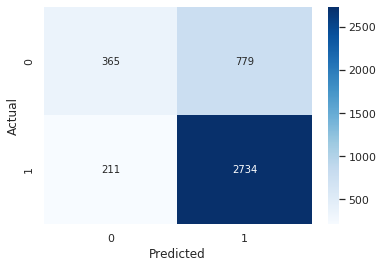

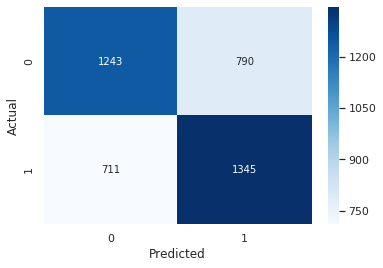

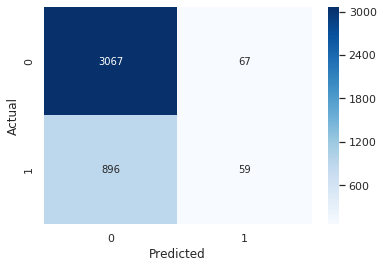

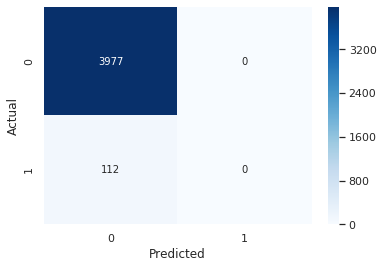

In [0]:
for i in range(4):
  plot_confusion(test_y_class.iloc[:,i].values, predict_class_gbt3[i])

#### A hybrid approach combining re-sampling & one-class outlier detection:

The one-class anomaly / outlier detection by Mahalanobis distances measured on multivariate dimensional space might capture local information on these rare events, i.e. deviations from the multivariate means. The idea was inspired by and the codes of *MahalanobisOneclassClassifier()* were credited to the following articles:<br>
https://www.machinelearningplus.com/statistics/mahalanobis-distance/ <br>
https://towardsdatascience.com/extreme-rare-event-classification-a-straight-forward-solution-58a20ef56ef5 <br>
Besides, one-class SVM and Local outlier factor scores also served to create numerical features for outlier likelihoods of a data point.

To create outlier score features, we could firstly inspect the feature importance from the LightGBM benchmark model, or from other tree methods like XGBoost and Random Forest fitted to the training set, to extract important features greater than a threshold. The TF-IDF feature set was used for outlier detection tasks, as it guaranteed sufficient information inputted into the tree boosting model for feature selection by importances. Sub-dividing the important features into small groups or doing individually for the outlier score computation were two options depending on the dimensionality and speed of computation. One additional outlier feature per one inspected feature would retain most information. Customized setting below create 1 feature corresponding to outlier dectection of 7 features  in each group.

ADASYN was chosen for over-sampling, which will focus on the samples which are difficult to classify with a nearest-neighbors rule; and Edited Nearest Neighbours was selected for under-sampling, samples of the majority class for which their class differ from the one of their nearest-neighbors will be removed.

Results could be compared to validate the best combinations on predicting each of the ordinal classes of the test data. To transform back to the label-encoded adoption speed vector, we could select the class which has the largest predicted probability of being positive.


In [0]:
## Step-wise learning using the re-sampling technique

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler

class resample:
  def __init__(self, train_set):
    self.train_set = train_set 
    self.train_set = self.train_set.fillna(-99)
    self.train_set = self.train_set.apply(pd.to_numeric)
    
  def split_train_test(self):
    self.train_X_class, self.test_X_class, self.train_y_class, self.test_y_class = train_test_split(
            self.train_set.iloc[:,0:self.train_set.shape[1]-5], 
            self.train_set.iloc[:,self.train_set.shape[1]-4:self.train_set.shape[1]],
            stratify = self.train_set.iloc[:,self.train_set.shape[1]-4:self.train_set.shape[1]],
            test_size=3/11, shuffle=True, random_state=42)
    return self.train_X_class, self.test_X_class, self.train_y_class, self.test_y_class
  
  def standardize_train(self, train_X, test_X):
    scale = StandardScaler()
    scale.fit(train_X)
    self.scale_train_set = scale.fit_transform(train_X)
    self.scale_train_set = pd.DataFrame(self.scale_train_set)
    self.scale_train_set.columns = train_X.columns
    self.scale_test_set = scale.transform(test_X)
    self.scale_test_set = pd.DataFrame(self.scale_test_set)
    self.scale_test_set.columns = test_X.columns

    return self.scale_train_set, self.scale_test_set
    
  def smote_oversample(self, c, train_X, train_y):
      smote = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=2)
      train_X_class_res, train_y_class_res = smote.fit_resample(
          np.array(train_X), np.array(train_y.iloc[:, c]))
      
      train_X_class_res = pd.DataFrame(train_X_class_res)
      train_X_class_res.columns = train_X.columns
      train_y_class_res = pd.DataFrame(train_y_class_res)
      train_y_class_res.columns = [train_y.columns[c]]
      
      return train_X_class_res, train_y_class_res

  def smote_undersample(self, c, train_X, train_y):
      smote = EditedNearestNeighbours(sampling_strategy='auto', random_state=42, n_neighbors=2)
      train_X_class_res, train_y_class_res = smote.fit_resample(
          np.array(train_X), np.array(train_y.iloc[:, c]))
    
      train_X_class_res = pd.DataFrame(train_X_class_res)
      train_X_class_res.columns = train_X.columns
      train_y_class_res = pd.DataFrame(train_y_class_res)
      train_y_class_res.columns = [train_y.columns[c]]

      return train_X_class_res, train_y_class_res

  def train_resampled_classifier(self, c, num_iterations, n_estimators, learning_rate, 
                                num_leaves, max_depth, min_data_in_leaf,
                                train_X_class_res, train_y_class_res, train_X_class,
                                test_X_class, test_y_class):
  
    GB_class = lgb.LGBMClassifier(boosting_type='gbdt', objective='cross_entropy', 
                                  num_iterations=num_iterations, n_estimators=n_estimators, 
                                  learning_rate=learning_rate, num_leaves=num_leaves, max_depth=max_depth, 
                                  n_jobs=4, min_data_in_leaf=min_data_in_leaf, unbalance=True, 
                                  random_state=42, lambda_l1=0.1, lambda_l2=0.01)

    predict_class = []
    importance_class = []
    qwck_class = []
    optR2 = OptimizedRounder2()

    for train_index, test_index in skf.split(train_X_class_res, train_y_class_res):
        X_train, X_val = train_X_class_res.iloc[train_index], train_X_class_res.iloc[test_index]
        y_train, y_val = train_y_class_res.iloc[train_index], train_y_class_res.iloc[test_index]

        model = GB_class.fit(X_train, y_train, eval_metric=['auc'],
                              eval_set=[(X_val, y_val)], verbose = True)

    predict_class.append(model.predict(test_X_class))
    pred_prob = model.predict_proba(test_X_class)
    training_pred = model.predict(train_X_class)
    importance_class.append(pd.DataFrame(sorted(zip(model.feature_importances_, 
                                                    train_X_class_res.columns)), 
                                         columns=['Value','Feature']))
    optR2.fit(predict_class[0], test_y_class.iloc[:,c].values)
    coefficients = optR2.coefficients()
    cutoff_class = optR2.predict(predict_class[0], coefficients)
    qwck_class.append(quadratic_weighted_kappa(test_y_class.iloc[:,c].values, cutoff_class))

    return model, training_pred, cutoff_class, pred_prob, importance_class, qwck_class

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
## Mahalanobis distance for anomaly detections
## Local Outlier Factor scores
## One-class SVM scores
from scipy.stats import chi2
import scipy as sp
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

def mahalanobis_computation(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data).values.reshape(1,-1)    
    if not cov:
        cov = np.cov(data.values.T)
    if cov.shape == ():
        cov = cov.reshape(1,1)
    inv_covmat = sp.linalg.inv(cov) 
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahalanobis = np.dot(left_term, x_minus_mu.T)
    return mahalanobis.diagonal()

class MahalanobisOneclassClassifier:
    def __init__(self, x_train, significance_level=0.01):
        self.x_train = x_train
        self.critical_value = chi2.ppf((1-significance_level), df=x_train.shape[1]-1)

    def predict_proba(self, x_test):
        mahalanobis_dist = mahalanobis_computation(x_test, self.x_train)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, x_test):
        return np.array([int(i) for i in self.predict_proba(x_test) > self.critical_value])

class create_new_outlier_score_features:
  def __init__(self, train_X, test_X, train_y):
    self.train_X = train_X
    self.train_y = train_y
    self.test_X = test_X

  def extract_feat_imp(self):
    ## use XGBoost to filter feature with importance > 0.001
    xgbc = xgb.XGBClassifier(n_estimators=1000, subsample=0.9, max_depth=10, max_features=0.9, 
                             random_state=42, n_jobs=4)
    xgbc.fit(self.train_X, self.train_y)

    ## generate a list of descending-sorted feature importance with a cut-off on 0.001
    feat_imp = pd.DataFrame((zip(xgbc.feature_importances_, self.train_X.columns)), 
                            columns=['Value','Feature'])[
                              pd.DataFrame((zip(xgbc.feature_importances_, self.train_X.columns)), 
                                          columns=['Value','Feature'])['Value']>=0.001].sort_values(
                                              ['Value'], ascending=False)
    return xgbc, feat_imp

  def generate_mahalanobis_dist_anomaly_score(self, k, feat_imp):
    ## k variables as one group to calculate outlier factor scores; 
    ## applied on the dataset of base features + tfidf features + image features
    ## generate new features of mahalanobis distances representing the extent / likelihood of being an outlier for each training data
    mahalanobis_anomaly_classifier = []
    for f in range(0, len(feat_imp), k):
      if not (f + k > len(feat_imp)):
        feat = []
        for s in range(k):
          feat.append(feat_imp.iloc[f + s, 1])
        extracted_feature_set = self.train_X[feat]
        mac = MahalanobisOneclassClassifier(extracted_feature_set, significance_level=0.01)
    
        mahalanobis_vec_train = mac.predict_proba(self.train_X[feat])
        mahalanobis_vec_test = mac.predict_proba(self.test_X[feat])
        mahalanobis_anomaly_classifier.append(mac)
        if f == 0:
          mahalanobis_anomaly_proba1 = mahalanobis_vec_train
          mahalanobis_anomaly_proba2 = mahalanobis_vec_test
        else:
          mahalanobis_anomaly_proba1 = np.hstack((mahalanobis_anomaly_proba1, mahalanobis_vec_train))
          mahalanobis_anomaly_proba2 = np.hstack((mahalanobis_anomaly_proba2, mahalanobis_vec_test))
        
    mahalanobis_anomaly_proba1 = mahalanobis_anomaly_proba1.reshape(len(self.train_X), -1)
    mahalanobis_anomaly_proba2 = mahalanobis_anomaly_proba2.reshape(len(self.test_X), -1)

    mahalanobis_anomaly_features_train = pd.DataFrame(mahalanobis_anomaly_proba1)
    mahalanobis_anomaly_features_test = pd.DataFrame(mahalanobis_anomaly_proba2)

    f_names = []
    for i in range(mahalanobis_anomaly_features_train.shape[1]):
      f_names.append("maha_dist_feature_" + str(i+1))
    mahalanobis_anomaly_features_train.columns = [f_names]
    mahalanobis_anomaly_features_test.columns = [f_names]

    return mahalanobis_anomaly_features_train, mahalanobis_anomaly_features_test

class Local_outlier_factor:
  def __init__(self, x_train_res):
    self.x_train_res = x_train_res

  def fit_predict_lof(self, x_train, x_test):
    lof = LocalOutlierFactor(n_neighbors=15, metric='minkowski', p=2, novelty=True, n_jobs=4)
    outlier_train = lof.fit(self.x_train_res)
    outlier_score_train = lof.predict(x_train)
    outlier_score_test = lof.predict(x_test)

    outlier_score_train = pd.DataFrame(outlier_score_train.reshape(len(outlier_score_train),-1))
    outlier_score_train.columns = ["lof_outlier_score"]
    outlier_score_test = pd.DataFrame(outlier_score_test.reshape(len(outlier_score_test),-1))
    outlier_score_test.columns = ["lof_outlier_score"]
    return outlier_score_train, outlier_score_test

class SVM_outlier:
  def __init__(self, x_train_res):
    self.x_train_res = x_train_res

  def fit_predict_svm(self, x_train, x_test):
    one_class_svm = OneClassSVM(max_iter=1000)
    outlier_train = one_class_svm.fit(self.x_train_res)
    outlier_score_train = one_class_svm.score_samples(x_train)
    outlier_score_test = one_class_svm.score_samples(x_test)

    outlier_score_train = pd.DataFrame(outlier_score_train.reshape(len(outlier_score_train),-1))
    outlier_score_train.columns = ["one_class_svm_outlier_score"]
    outlier_score_test = pd.DataFrame(outlier_score_test.reshape(len(outlier_score_test),-1))
    outlier_score_test.columns = ["one_class_svm_outlier_score"]
    return outlier_score_train, outlier_score_test

In [0]:
## use the dataset with Base features + TFIDF features + processed Image features
train_X_class, test_X_class, train_y_class, test_y_class = resample(target_X_all_tfidf).split_train_test()

In [0]:
## standardize dataset
scale_train_X_class, scale_test_X_class = resample(target_X_all_tfidf).standardize_train(train_X_class, test_X_class)

In [0]:
## define new concatenated dataset with outlier score features
xgb_list = []
feat_imp_list = []
features_train_list, features_test_list = [], []
lof_features_train_list, lof_features_test_list = [], []
svm_features_train_list, svm_features_test_list = [], []

for i in [0, 2, 3]:
  xgbc, feat_imp = create_new_outlier_score_features(scale_train_X_class, scale_test_X_class, 
                                                     train_y_class.iloc[:,i]).extract_feat_imp()
  xgb_list.append(xgbc)
  feat_imp_list.append(feat_imp)

  mahalanobis_anomaly_features_train, mahalanobis_anomaly_features_test = \
      create_new_outlier_score_features(scale_train_X_class, scale_test_X_class, train_y_class.iloc[:,i]
                                        ).generate_mahalanobis_dist_anomaly_score(7, feat_imp)
  features_train_list.append(mahalanobis_anomaly_features_train)
  features_test_list.append(mahalanobis_anomaly_features_test)

  lof_outlier_features_train, lof_outlier_features_test = Local_outlier_factor(scale_train_X_class).fit_predict_lof(scale_test_X_class)
  svm_outlier_features_train, svm_outlier_features_test = SVM_outlier(scale_train_X_class).fit_predict_svm(scale_test_X_class)

  lof_features_train_list.append(lof_outlier_features_train)
  lof_features_test_list.append(lof_outlier_features_test)
  svm_features_train_list.append(svm_outlier_features_train)
  svm_features_test_list.append(svm_outlier_features_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
train_X_class_outlier_1 = pd.concat([scale_train_X_class, features_train_list[2], 
                                     lof_features_train_list[2], svm_features_train_list[2]], axis=1)
test_X_class_outlier_1 = pd.concat([scale_test_X_class, features_test_list[2], 
                                    lof_features_test_list[2], svm_features_test_list[2]], axis=1)
train_X_class_outlier_7 = pd.concat([scale_train_X_class, features_train_list[1], 
                                     lof_features_train_list[1], svm_features_train_list[1]], axis=1)
test_X_class_outlier_7 = pd.concat([scale_test_X_class, features_test_list[1], 
                                    lof_features_test_list[1], svm_features_test_list[1]], axis=1)
train_X_class_outlier_90 = pd.concat([scale_train_X_class, features_train_list[0], 
                                      lof_features_train_list[0], svm_features_train_list[0]], axis=1)
test_X_class_outlier_90 = pd.concat([scale_test_X_class, features_test_list[0], 
                                     lof_features_test_list[0], svm_features_test_list[0]], axis=1)                       

In [0]:
## scaling the outlier score features generated
scale_1 = StandardScaler()
scale_7 = StandardScaler()
scale_90 = StandardScaler()
scale_1.fit(train_X_class_outlier_1.iloc[:,-52:])
scale_7.fit(train_X_class_outlier_7.iloc[:,-34:])
scale_90.fit(train_X_class_outlier_90.iloc[:,-34:])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
train_X_class_outlier_1 = pd.concat([scale_train_X_class, 
                                     pd.DataFrame(scale_1.transform(train_X_class_outlier_1.iloc[:,-52:]), 
                                                  columns=train_X_class_outlier_1.columns[-52:])], axis=1)
train_X_class_outlier_7 = pd.concat([scale_train_X_class, 
                                     pd.DataFrame(scale_7.transform(train_X_class_outlier_7.iloc[:,-34:]), 
                                                  columns=train_X_class_outlier_7.columns[-34:])], axis=1)
train_X_class_outlier_90 = pd.concat([scale_train_X_class, 
                                     pd.DataFrame(scale_90.transform(
                                         train_X_class_outlier_90.iloc[:,-34:]), 
                                         columns=train_X_class_outlier_90.columns[-34:])], axis=1)
test_X_class_outlier_1 = pd.concat([scale_test_X_class, 
                                    pd.DataFrame(scale_1.transform(test_X_class_outlier_1.iloc[:,-52:]), 
                                                 columns=test_X_class_outlier_1.columns[-52:])], axis=1)
test_X_class_outlier_7 = pd.concat([scale_test_X_class, 
                                    pd.DataFrame(scale_7.transform(test_X_class_outlier_7.iloc[:,-34:]), 
                                                 columns=test_X_class_outlier_7.columns[-34:])], axis=1)
test_X_class_outlier_90 = pd.concat([scale_test_X_class, 
                                     pd.DataFrame(scale_90.transform(
                                         test_X_class_outlier_90.iloc[:,-34:]), 
                                         columns=test_X_class_outlier_90.columns[-34:])], axis=1)

In [0]:
Dataset_with_outlier_features_1 = pd.concat(
    [pd.concat([train_X_class_outlier_1, train_y_class.reset_index(drop=True)], axis=1), 
     pd.concat([test_X_class_outlier_1, test_y_class.reset_index(drop=True)], axis=1)], axis=0)
Dataset_with_outlier_features_7 = pd.concat(
    [pd.concat([train_X_class_outlier_7, train_y_class.reset_index(drop=True)], axis=1), 
     pd.concat([test_X_class_outlier_7, test_y_class.reset_index(drop=True)], axis=1)], axis=0)
Dataset_with_outlier_features_90 = pd.concat(
    [pd.concat([train_X_class_outlier_90, train_y_class.reset_index(drop=True)], axis=1), 
     pd.concat([test_X_class_outlier_90, test_y_class.reset_index(drop=True)], axis=1)], axis=0)

In [0]:
print(Dataset_with_outlier_features_1.shape)
print(Dataset_with_outlier_features_7.shape)
print(Dataset_with_outlier_features_90.shape)
print(train_X_class_outlier_1.shape)
print(test_X_class_outlier_1.shape)
print(train_X_class_outlier_7.shape)
print(test_X_class_outlier_7.shape)
print(train_X_class_outlier_90.shape)
print(test_X_class_outlier_90.shape)

(14993, 8806)
(14993, 8792)
(14993, 8786)
(10904, 8802)
(4089, 8802)
(10904, 8788)
(4089, 8788)
(10904, 8782)
(4089, 8782)


In [0]:
## re-sample the three extreme proportional classes: "same day" & "within 7 days" & "no adoption within 90 days"
## we did not resample the 30-day class as the 30-day class had a closely balanced positive and negative ratio
train_X_class_ores_1_day, train_y_class_ores_1_day = \
resample(Dataset_with_outlier_features_1).smote_oversample(3, train_X_class_outlier_1, train_y_class)
train_X_class_ores_7_day, train_y_class_ores_7_day = \
resample(Dataset_with_outlier_features_7).smote_oversample(2, train_X_class_outlier_7, train_y_class)
train_X_class_ores_90_day, train_y_class_ores_90_day = \
resample(Dataset_with_outlier_features_90).smote_oversample(0, train_X_class_outlier_90, train_y_class)

In [0]:
train_X_class_ures_1_day, train_y_class_ures_1_day = \
resample(Dataset_with_outlier_features_1).smote_undersample(3, train_X_class_outlier_1, train_y_class)
train_X_class_ures_7_day, train_y_class_ures_7_day = \
resample(Dataset_with_outlier_features_7).smote_undersample(2, train_X_class_outlier_7, train_y_class)
train_X_class_ures_90_day, train_y_class_ures_90_day = \
resample(Dataset_with_outlier_features_90).smote_undersample(0, train_X_class_outlier_90, train_y_class)

In [0]:
LGB_ores_1_day, train_ores_1_day, cutoff_class_ores_1_day, pred_prob_ores_1_day, \
importance_class_ores_1_day, qwck_class_ores_1_day = \
resample(Dataset_with_outlier_features_1).train_resampled_classifier(
                      c=3, num_iterations=1000, n_estimators=300, learning_rate=0.001, 
                      num_leaves=300, max_depth=100, min_data_in_leaf=10,
                      train_X_class_res=train_X_class_ores_1_day, 
                      train_y_class_res=train_y_class_ores_1_day,
                      train_X_class=train_X_class_outlier_1,
                      test_X_class=test_X_class_outlier_1, 
                      test_y_class=test_y_class)

In [0]:
LGB_ores_7_day, train_ores_7_day, cutoff_class_ores_7_day, pred_prob_ores_7_day, \
importance_class_ores_7_day, qwck_class_ores_7_day = \
resample(Dataset_with_outlier_features_7).train_resampled_classifier(
                      c=2, num_iterations=1000, n_estimators=300, learning_rate=0.001, 
                      num_leaves=300, max_depth=100, min_data_in_leaf=10,
                      train_X_class_res=train_X_class_ores_7_day, 
                      train_y_class_res=train_y_class_ores_7_day,
                      train_X_class=train_X_class_outlier_7,
                      test_X_class=test_X_class_outlier_7,
                      test_y_class=test_y_class)

In [0]:
LGB_ores_90_day, train_ores_90_day, cutoff_class_ores_90_day, pred_prob_ores_90_day, \
importance_class_ores_90_day, qwck_class_ores_90_day = \
resample(Dataset_with_outlier_features_90).train_resampled_classifier(
                      c=0, num_iterations=1000, n_estimators=300, learning_rate=0.001, 
                      num_leaves=300, max_depth=100, min_data_in_leaf=1,
                      train_X_class_res=train_X_class_ores_90_day, 
                      train_y_class_res=train_y_class_ores_90_day,
                      train_X_class=train_X_class_outlier_90,
                      test_X_class=test_X_class_outlier_90,
                      test_y_class=test_y_class)

In [0]:
LGB_ures_1_day, train_ures_1_day, cutoff_class_ures_1_day, pred_prob_ures_1_day, \
importance_class_ures_1_day, qwck_class_ures_1_day = \
resample(Dataset_with_outlier_features_1).train_resampled_classifier(
                      c=3, num_iterations=1000, n_estimators=300, learning_rate=0.001, 
                      num_leaves=300, max_depth=100, min_data_in_leaf=10,
                      train_X_class_res=train_X_class_ures_1_day, 
                      train_y_class_res=train_y_class_ures_1_day,
                      train_X_class=train_X_class_outlier_1,
                      test_X_class=test_X_class_outlier_1, 
                      test_y_class=test_y_class)

In [0]:
LGB_ures_7_day, train_ures_7_day, cutoff_class_ures_7_day, pred_prob_ures_7_day, \
importance_class_ures_7_day, qwck_class_ures_7_day = \
resample(Dataset_with_outlier_features_7).train_resampled_classifier(
                      c=2, num_iterations=1000, n_estimators=300, learning_rate=0.001, 
                      num_leaves=300, max_depth=100, min_data_in_leaf=10,
                      train_X_class_res=train_X_class_ures_7_day, 
                      train_y_class_res=train_y_class_ures_7_day,
                      train_X_class=train_X_class_outlier_7,
                      test_X_class=test_X_class_outlier_7,
                      test_y_class=test_y_class)

In [0]:
LGB_ures_90_day, train_ures_90_day, cutoff_class_ures_90_day, pred_prob_ures_90_day, \
importance_class_ures_90_day, qwck_class_ures_90_day = \
resample(Dataset_with_outlier_features_90).train_resampled_classifier(
                      c=0, num_iterations=1000, n_estimators=300, learning_rate=0.001, 
                      num_leaves=300, max_depth=100, min_data_in_leaf=10,
                      train_X_class_res=train_X_class_ures_90_day, 
                      train_y_class_res=train_y_class_ures_90_day,
                      train_X_class=train_X_class_outlier_90,
                      test_X_class=test_X_class_outlier_90,
                      test_y_class=test_y_class)

#### Results Summary:

Following to the parameter settings of the benchmark model, some had been fine-tuned with same other values:

<ul>
<li>Benchmark model:
   <ul><li>Base feature only:
        <ul><li>qudratically-weighted Cohen's Kappa for regression setting = 0.2330; </li>
            <li>90-day and 30-day prediction got scores around 0.24 - 0.27 </li>
            <li>1-day and 3-day prediction scores were highly affected by imbalanceness dropping to around 0.01 </li></ul></li>
        <li>Base feature + TF-IDF feature + Image feature:
        <ul><li>qudratically-weighted Cohen's Kappa for regression setting = 0.2115; </li>
            <li>90-day and 30-day prediction got scores around 0.15 - 0.25 </li>
            <li>1-day and 3-day prediction scores were highly affected by imbalanceness dropping to around 0.01 </li></ul></li>
        <li>Base feature + Doc2Vec feature + Image feature:
        <ul><li>qudratically-weighted Cohen's Kappa for regression setting = 0.3390; </li>
            <li>90-day and 30-day prediction got scores around 0.26 - 0.29 </li>
            <li>1-day and 3-day prediction scores were highly affected by imbalanceness; <br>
                3-day class score got around 0.05; while 1-day class recorded all negative-only predictions and got a 0.00 score</li></ul></li></ul></li>

<li>Best refitted models for imbalanced classes considering anomaly features and resampling:
   <ul><li>"Adoption within 1 day (same day)":
        <ul><li>ADASYN with 2 nearest neighbours (custom selection) to over-sample the rare class gave better performance; <br> unpleasant trial results on setting n_neighour >= 5; </li>
            <li>increased quadratically-weighted Cohen's Kappa from 0.01 of the benchmark models to 0.07 </li>
            <li>recall and F1-score of the minority class boosted from 0.01 to 0.05 and from 0.02 to 0.08 respectively </li></ul></li>
        <li>"Adoption within 7 day (first week)":
        <ul><li>Edited Nearest Neighbors with 2 nearest neighbours (custom selection) to undersample the majority class gave better performance; much faster execution compared with Condensed Nearest Neighbours and One-sided selection algorithms;
            <li>increased quadratically-weighted Cohen's Kappa from 0.01 - 0.05 of the benchmark models to 0.16 </li>
            <li>recall and F1-score of the minority class boosted from 0.02 to 0.20 and from 0.03 to 0.28 respectively </li></ul></li>           
        <li>"Adoption within 90 day (first 3 months)":
        <ul><li>ADASYN with 2 nearest neighbours (custom selection) to over-sample the rare class gave better performance; <br> unpleasant trial results on setting n_neighour >= 5; </li>
            <li>increased quadratically-weighted Cohen's Kappa from 0.15 - 0.24 of the benchmark models to over 0.36 </li>
            <li>recall and F1-score of the minority class boosted from 0.23 to 0.48 and from 0.35 to 0.53 respectively </li></ul></li>

Transforming the 4-class predicted probabilities to the label-encoded target, and measuring the quadratically-weighted Cohen's Kappa between this vector and the actual label column, the score boosted from 0.2330 to 0.4075 (the "30-day (first month)" class was balanced but parameter tuning got the score slighly increased from 0.24 - 0.27 to 0.29).

Gennerally, feature creation through unsupervised anomaly detection approach integrated with re-sampling methods successfully boosted the performance for the extreme classes, especially in terms of the recall and f1-score for the minority class, though the effects were rather limited in this dataset, this strategy still acts as a fast solution given the data are imbalanced and the features available might not be critical to deliver a more robust predictive capability.

In [0]:
print(quadratic_weighted_kappa(test_y_class.iloc[:,3].values, cutoff_class_ores_1_day))

0.07117860747754534


In [0]:
print(classification_report(test_y_class.iloc[:,3].values, cutoff_class_ores_1_day))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3977
           1       0.18      0.05      0.08       112

    accuracy                           0.97      4089
   macro avg       0.58      0.52      0.53      4089
weighted avg       0.95      0.97      0.96      4089



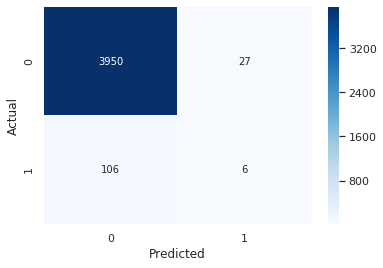

In [0]:
plot_confusion(test_y_class.iloc[:,3].values, cutoff_class_ores_1_day)

In [0]:
quadratic_weighted_kappa(test_y_class.iloc[:,2].values, cutoff_class_ures_7_day)

0.1594402811912411

In [0]:
print(classification_report(test_y_class.iloc[:,2].values, cutoff_class_ures_7_day))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85      3134
           1       0.45      0.20      0.28       955

    accuracy                           0.76      4089
   macro avg       0.62      0.56      0.57      4089
weighted avg       0.71      0.76      0.72      4089



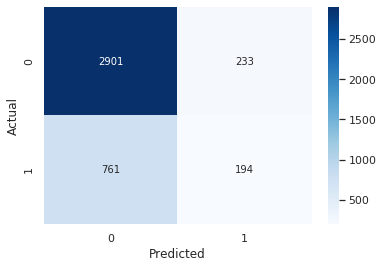

In [0]:
plot_confusion(test_y_class.iloc[:,2].values, cutoff_class_ures_7_day)

In [0]:
quadratic_weighted_kappa(test_y_class.iloc[:,0].values, cutoff_class_ores_90_day)

0.3659093160278266

In [0]:
print(classification_report(test_y_class.iloc[:,0].values, cutoff_class_ores_90_day))

              precision    recall  f1-score   support

           0       0.58      0.48      0.53      1144
           1       0.81      0.86      0.84      2945

    accuracy                           0.76      4089
   macro avg       0.70      0.67      0.68      4089
weighted avg       0.75      0.76      0.75      4089



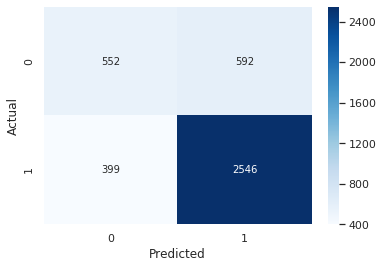

In [0]:
plot_confusion(test_y_class.iloc[:,0].values, cutoff_class_ores_90_day)

In [0]:
train_X_class_res_30_day, train_y_class_res_30_day = \
resample(target_X_pure).smote_undersample(1, train_X_class, train_y_class)

classifier = lgb.LGBMClassifier(boosting_type='gbdt', objective='cross_entropy', num_iterations=3000,
                                n_estimators=300, learning_rate=0.001, num_leaves=150, max_depth=-1, 
                                n_jobs=4, min_data_in_leaf=10, random_state=42,
                                lambda_l1=0.1, lambda_l2=0.01)

predict_class = []
predict_prob_30_day = []
importance_class = []
qwck_class = []
optR2 = OptimizedRounder2()

for train_index, test_index in skf.split(train_X_class, train_y_class.iloc[:,1]):
    X_train, X_val = train_X_class.iloc[train_index], train_X_class.iloc[test_index]
    y_train, y_val = train_y_class.iloc[train_index, 1], train_y_class.iloc[test_index, 1]

    class_ = classifier.fit(X_train, y_train, eval_metric=['auc'],
                            eval_set=[(X_val, y_val)], verbose = True)

predict_class.append(class_.predict(test_X_class))
predict_prob_30_day.append(class_.predict_proba(test_X_class))
importance_class.append(pd.DataFrame(sorted(zip(class_.feature_importances_, train_X_class.columns)), 
                                     columns=['Value','Feature']))
optR2.fit(predict_class[0], test_y_class.iloc[:,1].values)
coefficients = optR2.coefficients()
cutoff_class_30_day = optR2.predict(predict_class[0], coefficients)
qwck_class.append(quadratic_weighted_kappa(test_y_class.iloc[:,1].values, cutoff_class_30_day))

In [0]:
print(quadratic_weighted_kappa(test_y_class.iloc[:,1].values, cutoff_class_30_day))

0.29051174863865326


In [0]:
print(classification_report(test_y_class.iloc[:,1].values, cutoff_class_30_day))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63      2033
           1       0.64      0.68      0.66      2056

    accuracy                           0.65      4089
   macro avg       0.65      0.65      0.64      4089
weighted avg       0.65      0.65      0.64      4089



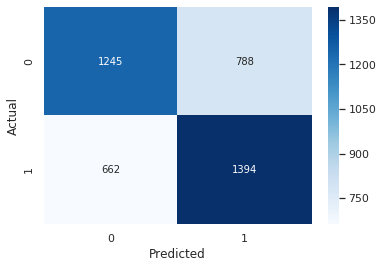

In [0]:
plot_confusion(test_y_class.iloc[:,1].values, cutoff_class_30_day)

In [0]:
## regenerate the adoption speed levels
pred = pd.concat([pd.DataFrame(pred_prob_ores_1_day[:,1]), pd.DataFrame(pred_prob_ures_7_day[:,1]),
                  pd.DataFrame(predict_prob_30_day[0][:,1]), pd.DataFrame(pred_prob_ores_90_day[:,1]),
                  pd.DataFrame(pred_prob_ores_1_day[:,0]), pd.DataFrame(pred_prob_ures_7_day[:,0]),
                  pd.DataFrame(predict_prob_30_day[0][:,0]), pd.DataFrame(pred_prob_ores_90_day[:,0])], 
                 axis=1)

qwck_adoption = []
for r in range(len(test_y_class)):
  most_propable_class = np.argmax(np.array(pred))
  if most_propable_class > 3:
    most_propable_class = 4
  qwck_adoption.append(most_propable_class)

In [0]:
print("Quad-weighted Cohen Kappa (on multiclass target): "  + '%.4f' % quadratic_weighted_kappa(test_y_reg, qwck_adoption))

Quad-weighted Cohen Kappa (on multiclass target): 0.4075
